# Identifying Top 5 Differentially Expressed Genes and Comparing Predictions with Observations

In this project, our main goal is to:

1. **Identify the top 5 differentially expressed genes** across multiple perturbation groups compared to a control group. We employ **two** main approaches for gene selection:  
   - **Approach A**: For each perturbation vs. control, take the top 10 or 20 genes; then select the genes that appear most frequently across all groups (the top 5).  
   - **Approach B**: For each gene, gather logFC and adjusted p-values from all perturbations. Calculate the maximum adjusted p-value (max_padj) and the mean absolute log2 fold change (mean_abs_logfc). Select the 5 genes with max_padj < 0.05 and the largest mean_abs_logfc.  

2. **Predict gene expression** for all conditions in the test set using a trained model (`gears_model`). We obtain an $(n \times m)$ predicted expression matrix, where $n$ is the number of test conditions and $m$ is the number of genes.  

3. **Obtain true observations** by calculating the mean gene expression for each condition in the original data (i.e., from `adata.X`). This also yields an $(n \times m)$ matrix.  

4. **Compare both predictions and true mean values** against the control group's average expression (`control_mean`). We then compute the absolute differences for the selected top 5 genes, which allows us to rank and visualize each condition by its distance from control.  

In [41]:
from gears import PertData, GEARS
import scanpy as sc
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import requests
import scipy as sp
from collections import Counter

In [42]:
# get data
pert_data = PertData('./data')
# load dataset in paper: norman, adamson, dixit, replogle_rpe1_essential, replogle_k562_essential
pert_data.load(data_name = 'adamson')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

# set up and train a model
gears_model = GEARS(pert_data, device = 'cpu')
#gears_model.model_initialize(hidden_size = 64)
#gears_model.train(epochs = 30)

# save/load model
#gears_model.save_model('gears_adamson')
gears_model.load_pretrained('gears_adamson')

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['SRPR+ctrl' 'SLMO2+ctrl' 'TIMM23+ctrl' 'AMIGO3+ctrl' 'KCTD16+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:21
Done!
Creating dataloaders....
Done!


here1


Splitting:  
Training: 54   	(66.67%)  
Testing: 21	    (25.93%)  
Validating: 6	(7.41%)  
Validating/(Validating + Training) = 10%

In [43]:
adata = pert_data.adata 

## Step 1: Select Top Differentially Expressed Genes Before and After Perturbation

This code introduces two methods to identify the top five differentially expressed genes from gene expression analysis data. The first method uses a Counter to track how often each gene appears in the top 10 across all perturbation groups, highlighting genes that are frequently identified as significant without considering their statistical values. The second method involves filtering genes based on adjusted p-values below 0.05 across all perturbations, then ranking these genes by their mean absolute log2 fold changes to prioritize those with the most substantial changes in expression, emphasizing their significance in multiple testing scenarios.


 Perform differential gene expression analysis on `adata.obs['condition']` using `sc.tl.rank_genes_groups` for grouping (groupby), specifying `reference='ctrl'`

This will calculate statistical metrics (e.g., p-value, log fold change) for "each condition vs. ctrl"

In [44]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='condition', 
    method='wilcoxon',  
    reference='ctrl'
)

In `adata.uns['rank_genes_groups']`, it contains:

**names[group]**: Gene rankings for each group.

**logfoldchanges[group]**: Corresponding log2 fold changes.

$$
\text{Log2 Fold Change (log2 FC)} = \log_2 \left( \frac{\text{Expression in Condition A}}{\text{Expression in Control Group}} \right)
$$

**pvals_adj[group]**: Adjusted p-values.

In [45]:
for key, value in adata.uns['rank_genes_groups'].items():
    print(f"Key: {key}")

Key: params
Key: names
Key: scores
Key: pvals
Key: pvals_adj
Key: logfoldchanges


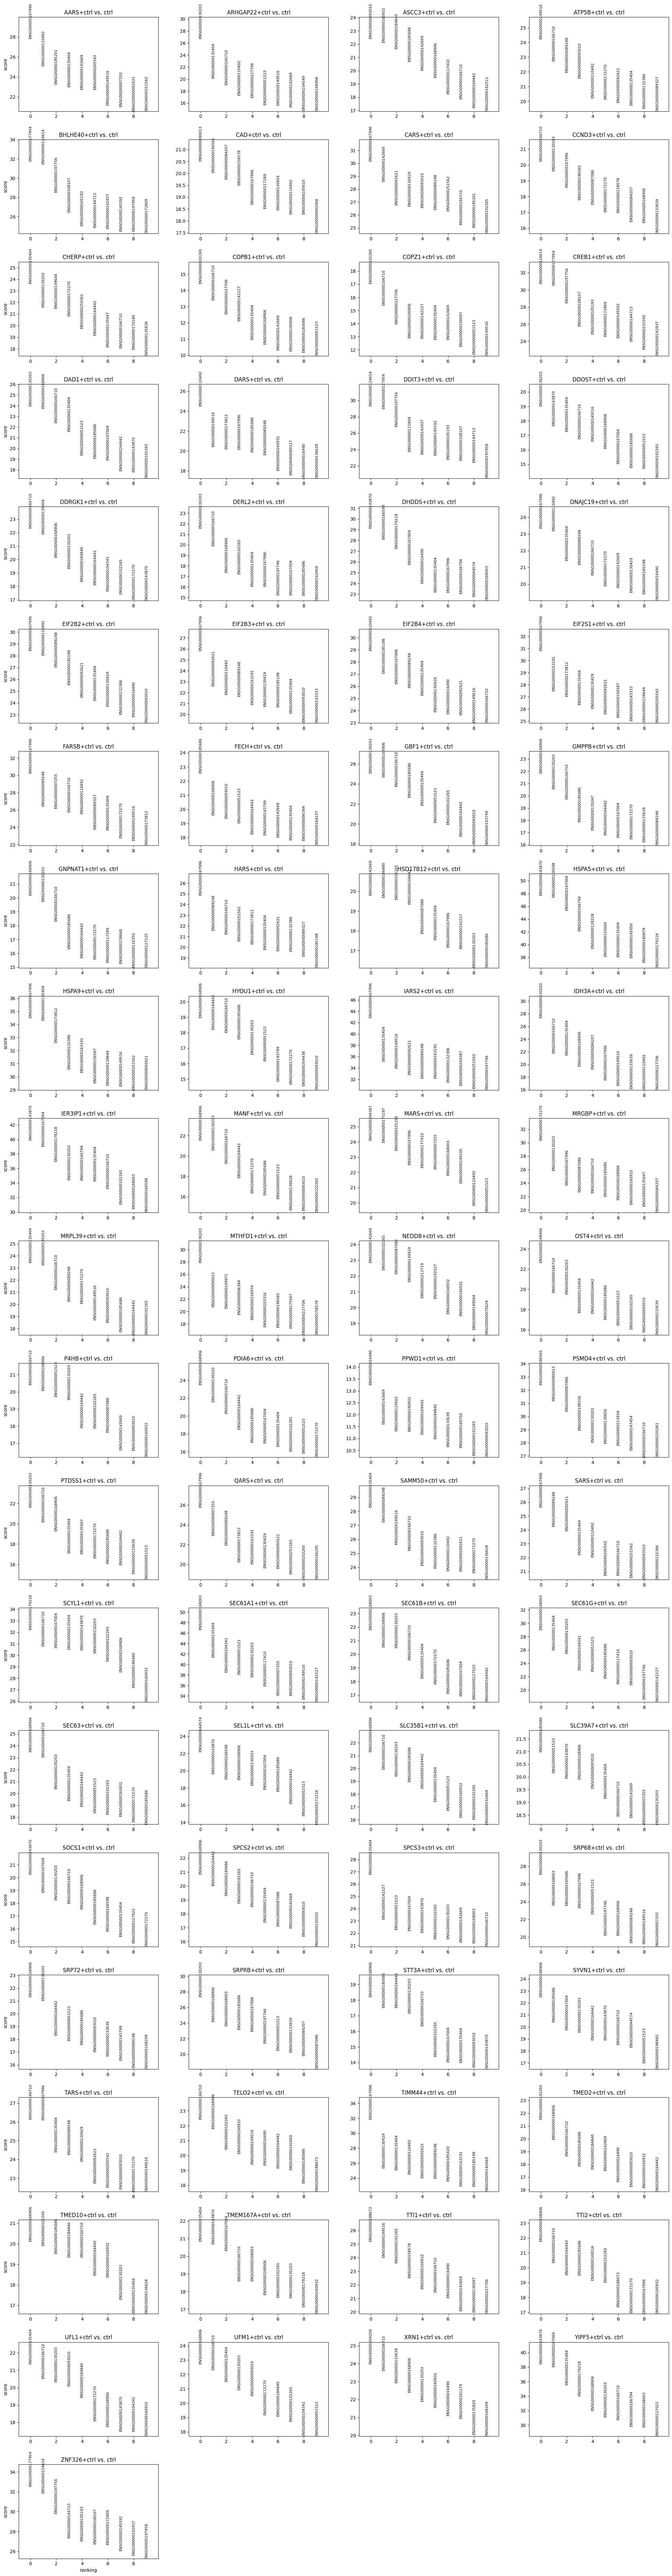

In [46]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

#### 1.1.1  Select the Top 5 Most Frequently Upregulated Genes from the Top 10 Across All Perturbation Groups (Method 1)

In [47]:
result = adata.uns['rank_genes_groups']
groups_to_compare = list(result['names'].dtype.names)  # All group names (excluding ctrl)
print("The number of total perturbation groups:")
print(len(groups_to_compare))

# Count the genes that appeared in the "top 10" of each perturbation group
n_top = 10
gene_counter = Counter()
top_diff_genes_1_pos = []

for grp in groups_to_compare:
    lfc_array = result['logfoldchanges'][grp]
    names_array = result['names'][grp]

    # Find all downregulated genes with logFC > 0
    pos_idx = np.where(lfc_array > 0)[0]
    pos_names = names_array[pos_idx]

    top_pos_names = pos_names[:n_top]  # Top-ranked n_top genes for this group vs. ctrl
    gene_counter.update(top_pos_names)

# Find the top 5 most frequently appearing genes
most_common_5 = gene_counter.most_common(5)

gene_id2name = dict(zip(adata.var.index, adata.var['gene_name'])) # gene_id -> gene_name

for gene_id, count in most_common_5:
    gene_symbol = gene_id2name.get(gene_id, gene_id)
    idx = adata.var.index.get_loc(gene_id)
    top_diff_genes_1_pos.append({'index': idx, 'gene_name': gene_symbol, 'count': count})
    print(idx, gene_symbol, gene_id, count)

The number of total perturbation groups:
81
3721 B2M ENSG00000166710 53
3277 CD63 ENSG00000135404 50
4767 APOE ENSG00000130203 45
745 MAT2A ENSG00000168906 42
4901 PRAME ENSG00000185686 35


#### 1.1.2 Select the Top 5 Most Frequently Downregulated Genes from the Top 10 Across All Perturbation Groups (Method 1)

In [48]:
n_top = 10
gene_counter = Counter()
top_diff_genes_1_neg = []

for grp in groups_to_compare:
    lfc_array = result['logfoldchanges'][grp]
    names_array = result['names'][grp]
    
    # Find all downregulated genes with logFC < 0
    neg_idx = np.where(lfc_array < 0)[0]          
    neg_names = names_array[neg_idx]      
    
    top_neg_names = neg_names[:n_top]

    gene_counter.update(top_neg_names)

most_common_5 = gene_counter.most_common(5)

gene_id2name = dict(zip(adata.var.index, adata.var['gene_name']))  # gene_id -> gene_name

for gene_id, count in most_common_5:
    gene_symbol = gene_id2name.get(gene_id, gene_id)
    idx = adata.var.index.get_loc(gene_id)
    top_diff_genes_1_neg.append({'index': idx, 'gene_name': gene_symbol, 'count': count})
    print(idx, gene_symbol, gene_id, count)

3234 TUBA1B ENSG00000123416 22
3441 HMGB1 ENSG00000189403 16
2537 NDUFB6 ENSG00000165264 12
5020 SON ENSG00000159140 11
2553 STOML2 ENSG00000165283 11


#### 1.2 Calculate metrics for top 5 genes that are significant and have large differences across all groups (Method 2)

In [49]:
n_genes_to_extract = adata.shape[1] # number of genes
genes_info = {}  # dict: {gene_name: {group: (logfc, pval_adj)}} 

In [50]:
#   result['names'][g][k]          Name of the k-th most significant gene for group g
#   result['pvals_adj'][g][k]      Corresponding adjusted p-value
#   result['logfoldchanges'][g][k] Corresponding log2(FC)

for g in groups_to_compare:
    gene_names_g = result['names'][g][:n_genes_to_extract]
    logfold_g    = result['logfoldchanges'][g][:n_genes_to_extract]
    pvals_adj_g  = result['pvals_adj'][g][:n_genes_to_extract]

    for i, gene_name in enumerate(gene_names_g):
        lf = logfold_g[i]
        pv = pvals_adj_g[i]
        if gene_name not in genes_info:
            genes_info[gene_name] = {}
        genes_info[gene_name][g] = (lf, pv)

#  genes_info:
# 'ENSG00000167996': {'AARS+ctrl': (np.float32(1.0759454), np.float64(1.8382504557509487e-166)),
#                     'ARHGAP22+ctrl': (np.float32(0.30378848), np.float64(5.025147563365446e-44)),
#                     'ASCC3+ctrl': (np.float32(0.1702667), np.float64(7.609383257338828e-20)),
#                     'ATP5B+ctrl': (np.float32(0.30731493), np.float64(6.323029370509774e-61)),
#                     'BHLHE40+ctrl': (np.float32(-0.6284387), np.float64(3.5913572329834246e-186)),
#                     ……………………………………

Require all p-values < 0.05, and then select the top genes with the largest mean |log2FC|.

In [51]:
gene_stats = []
for gname, group_dict in genes_info.items():
    # Collect log2FC & p-values(lf, pv) for the gene in each perturbation group
    lf_list  = []
    pval_list= []
    # lf_list is a list that stores the log2 fold change values of the current gene across all perturbation groups.
    # pval_list is a list that stores the adjusted p-values of the current gene across all perturbation groups.
    for g in groups_to_compare:
        lf, pv = group_dict[g]
        lf_list.append(lf)
        pval_list.append(pv)
    # max_padj: The maximum adjusted p-value for the gene across all perturbations (smaller is better)
    # mean_abs_logFC: The mean absolute log2 fold change across all perturbations (larger is better)
    max_padj = np.max(pval_list) # Helps determine if a gene is statistically significant across all perturbation groups.
        # The smaller the max_padj, the more confident we can be that the gene is differentially expressed across conditions.
    mean_abs_logfc = np.mean(np.abs(lf_list)) # Measures the average magnitude of the gene's expression change across all perturbation groups, irrespective of direction.
        # A higher value indicates that the gene exhibits strong differential expression overall.

    gene_stats.append({
        'gene': gname,
        'max_padj': max_padj,
        'mean_abs_logfc': mean_abs_logfc,
    })

df_stats = pd.DataFrame(gene_stats)
df_stats.head(10)


gene      max_padj  mean_abs_logfc
0  ENSG00000167996  1.321211e-07        0.416960
1  ENSG00000110492  9.999212e-01        0.597778
2  ENSG00000185201  7.868245e-03        1.016870
3  ENSG00000135404  5.115437e-04        0.596663
4  ENSG00000142669  9.994002e-01        1.019920
5  ENSG00000205542  9.998100e-01        0.234631
6  ENSG00000149516  1.874976e-01        0.672607
7  ENSG00000007255  5.391380e-01        0.893081
8  ENSG00000092621  9.999586e-01        0.953852
9  ENSG00000251562  1.454111e-01        0.427357

In [52]:
top_diff_genes_2 = []

# Filter for significance requiring all comparisons to pass FDR < 0.05
df_stats_sig = df_stats[df_stats['max_padj'] < 0.05].copy()

# Then sort by mean absolute logFC in descending order
df_stats_sig.sort_values(by='mean_abs_logfc', ascending=False, inplace=True)

# Take the top 5
top5 = df_stats_sig.head(5)

top5['gene_name'] = top5['gene'].map(gene_id2name).fillna(top5['gene'])  # Use gene ID if no symbol is available

top5['index'] = top5['gene'].apply(lambda g: adata.var.index.get_loc(g))

top_diff_genes_2.extend(
    top5[['index', 'gene_name']].to_dict('records')
)

print("Top 5 genes that are significantly different (padj<0.05) in ALL conditions vs ctrl, with largest mean |log2FC|:")
print(top5[['gene', 'gene_name', 'max_padj', 'mean_abs_logfc']])

Top 5 genes that are significantly different (padj<0.05) in ALL conditions vs ctrl, with largest mean |log2FC|:
                 gene gene_name  max_padj  mean_abs_logfc
4980  ENSG00000180389   ATP5EP2  0.001947        1.606769
94    ENSG00000168298  HIST1H1E  0.004289        1.568831
4970  ENSG00000198918     RPL39  0.000348        1.237293
57    ENSG00000158869    FCER1G  0.006285        1.140540
4977  ENSG00000205246   RPSAP58  0.008634        1.131355


## Step 2: Compare the Impact of Different Perturbations on the Expression of the Top Genes

This code calculates control group means, and predict gene expression levels for test perturbations.

In [53]:
train_conditions = pert_data.set2conditions['train']
test_conditions = pert_data.set2conditions['test']
train_samples = pert_data.adata[pert_data.adata.obs['condition'].isin(train_conditions)]
control_mean = train_samples.X[train_samples.obs['condition'] == 'ctrl', :].toarray().mean(axis=0)  # Mean expression of control samples

predicted_list = []
for cond in test_conditions:
    parts = cond.split('+')
    gene_to_predict = [p for p in parts if p != 'ctrl'][0]
    Y_pred = gears_model.predict([[gene_to_predict]])  # Predict the expression of the gene
    predicted_list.append(Y_pred)

This code extracts predicted gene expression data from a list of dictionaries, organizes it into a DataFrame with perturbation groups as rows and gene names as columns.

In [54]:
arr_list = []
gene_names_arr = []

for item in predicted_list:
    gene_name = list(item.keys())[0]
    arr = item[gene_name]
    
    arr_list.append(arr)
    gene_names_arr.append(gene_name)

predicted_arr = np.vstack(arr_list)

In [55]:
df_pred = pd.DataFrame(
    predicted_arr,
    index=gene_names_arr,  # Perturbation group names
    columns=adata.var['gene_name']  # Gene names
)
df_pred

gene_name  AP006222.2  RP11-54O7.16  RP11-54O7.1  RP11-54O7.3    SAMD11  \
CREB1        0.002917  1.374254e-37     0.019841     0.006113  0.029626   
BHLHE40      0.004591  1.374254e-37     0.025948     0.008850  0.013091   
DDIT3        0.004322  1.374254e-37     0.018474     0.006113  0.013091   
HARS         0.004219  1.492550e-37     0.022491     0.008225  0.023370   
DAD1         0.002895  3.599563e-03     0.021792     0.005970  0.014237   
DDRGK1       0.002965  1.406319e-37     0.021534     0.007687  0.014685   
SAMM50       0.002995  1.503605e-37     0.018608     0.006234  0.015440   
CAD          0.005004  1.374254e-37     0.023137     0.009014  0.013091   
GNPNAT1      0.002959  1.458091e-37     0.020079     0.006157  0.013168   
TTI2         0.002503  4.433880e-38     0.018201     0.007081  0.013407   
MANF         0.009946  1.084444e-37     0.019473     0.007030  0.016958   
TARS         0.003062  1.601835e-37     0.020893     0.007535  0.013556   
EIF2B2       0.005241  1.237051e-37     0.026366     0.010020  0.019936   
ARHGAP22     0.002917  1.374254e-37     0.018474     0.006113  0.013091   
SRP72        0.002611  8.092851e-38     0.018008     0.006798  0.012304   
TMED10       0.002979  1.517960e-37     0.018475     0.007584  0.018889   
COPB1        0.005289  1.281313e-37     0.023478     0.009728  0.017072   
FECH         0.003033  1.560889e-37     0.024481     0.006287  0.017684   
DHDDS        0.002997  1.518104e-37     0.020083     0.006184  0.013189   
CARS         0.003156  1.619095e-37     0.019007     0.006480  0.015559   
TMED2        0.005078  1.506906e-37     0.022537     0.006152  0.013136   

gene_name      HES4     ISG15    TTLL10  TNFRSF18   TNFRSF4  ...     ITGB2  \
CREB1      0.438829  0.589988  0.044259  0.011256  0.034232  ...  0.080256   
BHLHE40    0.461137  0.599348  0.038870  0.009230  0.036404  ...  0.091553   
DDIT3      0.501226  0.562298  0.041995  0.016364  0.038304  ...  0.085984   
HARS       0.429558  0.579959  0.054849  0.011451  0.041799  ...  0.125663   
DAD1       0.448881  0.573324  0.039459  0.009462  0.036346  ...  0.070566   
DDRGK1     0.464405  0.631451  0.040344  0.009496  0.036091  ...  0.080514   
SAMM50     0.441708  0.590569  0.042094  0.009338  0.035680  ...  0.075502   
CAD        0.450322  0.606218  0.041096  0.011724  0.036726  ...  0.082193   
GNPNAT1    0.437306  0.579971  0.040682  0.009353  0.034797  ...  0.083866   
TTI2       0.465930  0.600620  0.041792  0.011168  0.031844  ...  0.078779   
MANF       0.427687  0.601794  0.051385  0.008959  0.035252  ...  0.085406   
TARS       0.442088  0.587418  0.045686  0.009474  0.042157  ...  0.076895   
EIF2B2     0.408110  0.655968  0.066173  0.013166  0.052153  ...  0.154448   
ARHGAP22   0.468667  0.601153  0.038870  0.009230  0.034232  ...  0.077078   
SRP72      0.415211  0.571077  0.036709  0.008499  0.031428  ...  0.072938   
TMED10     0.460546  0.588430  0.040883  0.009426  0.035195  ...  0.077129   
COPB1      0.415844  0.634010  0.053525  0.011107  0.046181  ...  0.097387   
FECH       0.443412  0.607291  0.045363  0.009417  0.034644  ...  0.085824   
DHDDS      0.474490  0.636994  0.041491  0.009480  0.035482  ...  0.076747   
CARS       0.429608  0.586239  0.042749  0.009631  0.035349  ...  0.096753   
TMED2      0.478819  0.588368  0.040855  0.009430  0.035273  ...  0.086635   

gene_name  ITGB2-AS1  LINC00205  BX322559.3   COL18A1  AL133493.2    COL6A1  \
CREB1       0.052898   0.049253    0.004235  0.658329    0.098667  0.000970   
BHLHE40     0.055471   0.049148    0.004235  0.707702    0.100620  0.000970   
DDIT3       0.052632   0.059008    0.005901  0.732274    0.094927  0.000970   
HARS        0.052383   0.062188    0.003968  0.626581    0.085699  0.000833   
DAD1        0.052142   0.048702    0.004607  0.657665    0.115187  0.001125   
DDRGK1      0.061538   0.058943    0.004430  0.681431    0.112283  0.001076   
SAMM50      0.053839   0.058571    0.004149  0.694085    0.125971  0.000952   


This code calculates the actual mean gene expression levels for each perturbation in `test_conditions` from `adata`, stacks these into a numpy array, and creates a DataFrame `df_true` indexed by perturbation and labeled by gene names.

In [56]:
test_true_list = []

for cond in test_conditions:
    sub_adata = adata[adata.obs['condition'] == cond]
    mean_expr = sub_adata.X.toarray().mean(axis=0)
    test_true_list.append(mean_expr)

test_arr = np.vstack(test_true_list)

df_true = pd.DataFrame(
    test_arr, 
    index=gene_names_arr, 
    columns=adata.var['gene_name']
)
df_true

gene_name  AP006222.2  RP11-54O7.16  RP11-54O7.1  RP11-54O7.3    SAMD11  \
CREB1        0.000000      0.000000     0.000000     0.001663  0.000000   
BHLHE40      0.000000      0.000000     0.000000     0.000000  0.001746   
DDIT3        0.000000      0.000000     0.004368     0.004156  0.002129   
HARS         0.003707      0.000000     0.002744     0.000000  0.004281   
DAD1         0.000000      0.000000     0.004520     0.001020  0.006956   
DDRGK1       0.000000      0.000000     0.005213     0.000000  0.002192   
SAMM50       0.000000      0.000000     0.008566     0.000000  0.004068   
CAD          0.000000      0.000000     0.002767     0.000000  0.000000   
GNPNAT1      0.001115      0.000000     0.001866     0.001488  0.000000   
TTI2         0.000000      0.000000     0.004488     0.000000  0.004961   
MANF         0.000000      0.000000     0.004722     0.003660  0.006525   
TARS         0.001154      0.000000     0.009203     0.000755  0.003162   
EIF2B2       0.002301      0.002142     0.010877     0.000000  0.002946   
ARHGAP22     0.000000      0.000000     0.002360     0.001548  0.004594   
SRP72        0.000000      0.000000     0.006416     0.000000  0.001514   
TMED10       0.000000      0.000000     0.007365     0.001057  0.008800   
COPB1        0.000000      0.000000     0.005016     0.000000  0.002948   
FECH         0.000000      0.000000     0.008316     0.001011  0.003326   
DHDDS        0.000000      0.000000     0.008039     0.002580  0.008822   
CARS         0.000000      0.000000     0.011612     0.000000  0.011482   
TMED2        0.001215      0.000000     0.005700     0.002676  0.005701   

gene_name      HES4     ISG15    TTLL10  TNFRSF18   TNFRSF4  ...     ITGB2  \
CREB1      0.237705  0.371811  0.001632  0.000000  0.000000  ...  0.008807   
BHLHE40    0.299651  0.513131  0.003570  0.000000  0.000000  ...  0.041841   
DDIT3      0.211416  0.382277  0.002191  0.000000  0.000000  ...  0.008204   
HARS       0.340340  0.632381  0.005727  0.000000  0.000000  ...  0.021916   
DAD1       0.486542  0.666481  0.010591  0.000000  0.001418  ...  0.022272   
DDRGK1     0.435741  0.618185  0.010214  0.004181  0.007285  ...  0.026419   
SAMM50     0.482507  0.642504  0.015593  0.000000  0.003662  ...  0.033412   
CAD        0.596245  0.655255  0.007348  0.003110  0.005184  ...  0.010378   
GNPNAT1    0.485457  0.669247  0.006332  0.001231  0.000000  ...  0.010878   
TTI2       0.451925  0.638855  0.006011  0.001256  0.002637  ...  0.032008   
MANF       0.477501  0.647743  0.010208  0.003660  0.004725  ...  0.021372   
TARS       0.454106  0.547275  0.011062  0.001103  0.002529  ...  0.041371   
EIF2B2     0.351751  0.616704  0.009320  0.003200  0.003551  ...  0.075742   
ARHGAP22   0.544437  0.728876  0.009140  0.001503  0.000000  ...  0.040304   
SRP72      0.462522  0.655528  0.006046  0.003132  0.000000  ...  0.020170   
TMED10     0.509659  0.652066  0.010959  0.002381  0.001512  ...  0.036118   
COPB1      0.505621  0.657282  0.000000  0.003597  0.036674  ...  0.039194   
FECH       0.516312  0.635553  0.011983  0.000000  0.001701  ...  0.036448   
DHDDS      0.416457  0.656309  0.013174  0.000000  0.004854  ...  0.025481   
CARS       0.400446  0.740968  0.024159  0.006138  0.007960  ...  0.171011   
TMED2      0.531318  0.632311  0.006598  0.004879  0.001553  ...  0.046075   

gene_name  ITGB2-AS1  LINC00205  BX322559.3   COL18A1  AL133493.2    COL6A1  \
CREB1       0.001727   0.007745    0.000000  0.521261    0.006162  0.000000   
BHLHE40     0.010160   0.003633    0.000000  0.451667    0.010821  0.000000   
DDIT3       0.004382   0.004345    0.000000  0.553989    0.008472  0.000000   
HARS        0.010933   0.025317    0.000000  0.421914    0.030224  0.000000   
DAD1        0.012813   0.025180    0.000000  0.746342    0.065566  0.000000   
DDRGK1      0.019636   0.017319    0.000000  0.687060    0.061503  0.001173   
SAMM50      0.011635   0.021146    0.000000  0.579214    0.038156  0.000000   


#### 2.1.1 Top 5 Upregulated Genes from Method 1

This code segment first constructs a list, `cols_1`, containing the gene names of the top 5 genes identified by frequency from `top_diff_genes_1`. It then extracts the corresponding prediction data for these genes from the DataFrame `df_pred` to create a new DataFrame `sub_pred_1`. This new DataFrame contains the predicted expression values specifically for the top 5 most frequently appearing genes.

In [57]:
cols_1_pos = [g['gene_name'] for g in top_diff_genes_1_pos] # Top 5 genes by frequency
sub_pred_1_pos = df_pred[cols_1_pos] # Predictions for the top 5 genes by frequency
sub_pred_1_pos

gene_name       B2M      CD63      APOE     MAT2A     PRAME
CREB1      3.277003  2.836455  3.030631  1.109966  2.417207
BHLHE40    3.192437  2.798694  3.069478  1.189942  2.414365
DDIT3      3.226433  2.803951  3.032672  1.119955  2.478912
HARS       3.297963  2.873847  2.867681  0.952353  2.396683
DAD1       3.228605  2.814743  3.081992  1.167315  2.415711
DDRGK1     3.247493  2.877320  3.093180  1.136217  2.410755
SAMM50     3.243953  2.815363  3.039074  1.117651  2.440462
CAD        3.220811  2.824268  3.047559  1.149660  2.414698
GNPNAT1    3.223619  2.768624  3.009804  1.091073  2.403822
TTI2       3.249756  2.834458  3.169642  1.144334  2.402199
MANF       3.233384  2.825955  3.028295  1.118472  2.443307
TARS       3.214242  2.847246  2.988700  1.143334  2.402454
EIF2B2     3.340495  2.932897  2.779576  0.873923  2.452603
ARHGAP22   3.254202  2.811844  3.069433  1.105156  2.388499
SRP72      3.213335  2.822189  2.973862  1.089798  2.391785
TMED10     3.236577  2.844411  3.054800  1.172659  2.427053
COPB1      3.257062  2.902043  2.966145  1.092814  2.485998
FECH       3.270913  2.827753  3.112907  1.129118  2.427832
DHDDS      3.241413  2.846236  3.037957  1.197134  2.405633
CARS       3.229362  2.776180  2.989140  1.085330  2.375865
TMED2      3.242955  2.793671  3.042899  1.193283  2.439861

Extract the mean expression levels of the control group for the top 5 most frequently mentioned genes.

In [58]:
control_1_pos = [control_mean[g['index']] for g in top_diff_genes_1_pos]  # Control mean expression for the top 5 genes by frequency
control_series_1_pos = pd.Series(control_1_pos, index=sub_pred_1_pos.columns) 
control_series_1_pos

gene_name
B2M      2.901298
CD63     2.566249
APOE     2.637413
MAT2A    0.801780
PRAME    2.129449
dtype: float32

Calculate the absolute differences between the predicted expression values and the true average expression levels of the control group.

In [59]:
diff_pred_1_pos = sub_pred_1_pos - control_series_1_pos  # Difference from control
diff_pred_1_pos

gene_name       B2M      CD63      APOE     MAT2A     PRAME
CREB1      0.375705  0.270206  0.393218  0.308186  0.287758
BHLHE40    0.291139  0.232445  0.432065  0.388163  0.284916
DDIT3      0.325135  0.237702  0.395259  0.318175  0.349463
HARS       0.396665  0.307598  0.230268  0.150573  0.267234
DAD1       0.327307  0.248494  0.444580  0.365535  0.286262
DDRGK1     0.346195  0.311071  0.455767  0.334438  0.281306
SAMM50     0.342655  0.249114  0.401662  0.315871  0.311013
CAD        0.319514  0.258019  0.410146  0.347881  0.285249
GNPNAT1    0.322321  0.202375  0.372392  0.289293  0.274373
TTI2       0.348458  0.268209  0.532230  0.342554  0.272750
MANF       0.332086  0.259706  0.390882  0.316692  0.313858
TARS       0.312944  0.280998  0.351288  0.341554  0.273005
EIF2B2     0.439197  0.366648  0.142163  0.072143  0.323154
ARHGAP22   0.352905  0.245595  0.432021  0.303376  0.259049
SRP72      0.312037  0.255940  0.336449  0.288018  0.262336
TMED10     0.335279  0.278162  0.417387  0.370879  0.297604
COPB1      0.355764  0.335794  0.328732  0.291034  0.356549
FECH       0.369616  0.261504  0.475495  0.327338  0.298383
DHDDS      0.340115  0.279988  0.400544  0.395354  0.276184
CARS       0.328064  0.209931  0.351727  0.283550  0.246416
TMED2      0.341657  0.227422  0.405486  0.391503  0.310412

In [60]:
# for gene_name in diff_abs_pred_1.columns:
#     diff_series = diff_abs_pred_1[gene_name]
#     # Sort the test conditions by the absolute difference in descending order    
#     sorted_diff_gene = diff_series.sort_values(ascending=False)
    
#     print(f"=== Ranking of test_conditions by absolute difference for gene '{gene_name}' ===")
#     print(sorted_diff_gene) # Print the sorted series
#     print("------")

This code retrieves actual expression data for the top 5 genes identified by frequency from the DataFrame `df_true`, storing it in `sub_true_1`.

In [61]:
cols_1_pos = [g['gene_name'] for g in top_diff_genes_1_pos]
sub_true_1_pos = df_true[cols_1_pos]
sub_true_1_pos

gene_name       B2M      CD63      APOE     MAT2A     PRAME
CREB1      2.622864  2.432472  2.339311  0.424563  1.987408
BHLHE40    2.660981  2.478268  2.034173  0.390589  1.964800
DDIT3      2.690163  2.411762  2.425307  0.449907  1.953061
HARS       3.640830  3.224127  2.676662  0.758807  2.416278
DAD1       3.325483  2.960875  3.212668  1.501407  2.491312
DDRGK1     3.359411  2.990242  3.124291  1.434848  2.452283
SAMM50     3.373549  3.069447  3.047306  1.177267  2.522191
CAD        3.458839  2.861890  3.301337  1.280264  2.256464
GNPNAT1    3.302658  2.802860  3.181102  1.518792  2.494312
TTI2       3.310097  2.857876  3.020250  1.489190  2.531996
MANF       3.327312  2.843186  3.191859  1.537048  2.481746
TARS       3.407955  3.005108  2.780949  1.156999  2.547751
EIF2B2     3.390717  3.073530  2.548836  0.905090  2.465916
ARHGAP22   3.351542  3.035784  3.521726  1.313405  2.444212
SRP72      3.107477  2.830956  3.217046  1.541012  2.526749
TMED10     3.280907  2.883934  3.071353  1.436743  2.526866
COPB1      3.382940  2.915159  3.083148  1.362991  2.493670
FECH       3.168359  2.889029  3.021607  1.376281  2.582696
DHDDS      3.423291  3.158735  3.236255  1.166612  2.492526
CARS       3.590082  3.167116  2.329983  0.689024  2.635002
TMED2      3.313993  2.882702  2.968692  1.482659  2.526123

Calculate the differences between the true expression values of each perturbation and the true average expression levels of the control group.

In [62]:
diff_true_1_pos = sub_true_1_pos - control_series_1_pos
diff_true_1_pos

gene_name       B2M      CD63      APOE     MAT2A     PRAME
CREB1     -0.278433 -0.133777 -0.298102 -0.377217 -0.142041
BHLHE40   -0.240317 -0.087981 -0.603239 -0.411191 -0.164649
DDIT3     -0.211135 -0.154487 -0.212106 -0.351873 -0.176388
HARS       0.739532  0.657878  0.039250 -0.042973  0.286829
DAD1       0.424185  0.394626  0.575256  0.699627  0.361863
DDRGK1     0.458113  0.423993  0.486878  0.633068  0.322834
SAMM50     0.472251  0.503198  0.409893  0.375487  0.392742
CAD        0.557541  0.295641  0.663924  0.478485  0.127015
GNPNAT1    0.401360  0.236611  0.543689  0.717012  0.364863
TTI2       0.408799  0.291627  0.382838  0.687410  0.402546
MANF       0.426014  0.276937  0.554446  0.735268  0.352297
TARS       0.506657  0.438859  0.143536  0.355219  0.418302
EIF2B2     0.489419  0.507281 -0.088576  0.103310  0.336467
ARHGAP22   0.450245  0.469535  0.884314  0.511625  0.314763
SRP72      0.206179  0.264707  0.579633  0.739232  0.397300
TMED10     0.379609  0.317685  0.433940  0.634963  0.397417
COPB1      0.481642  0.348911  0.445735  0.561211  0.364221
FECH       0.267061  0.322780  0.384194  0.574501  0.453247
DHDDS      0.521994  0.592486  0.598842  0.364832  0.363077
CARS       0.688784  0.600867 -0.307430 -0.112756  0.505553
TMED2      0.412695  0.316453  0.331279  0.680880  0.396674

In [63]:
# for gene_name in diff_abs_true_1.columns:
#     diff_series = diff_abs_true_1[gene_name]         
#     sorted_diff_gene = diff_series.sort_values(ascending=False)
    
#     print(f"=== Ranking of test_conditions by absolute difference for gene '{gene_name}' ===")
#     print(sorted_diff_gene)
#     print("------")

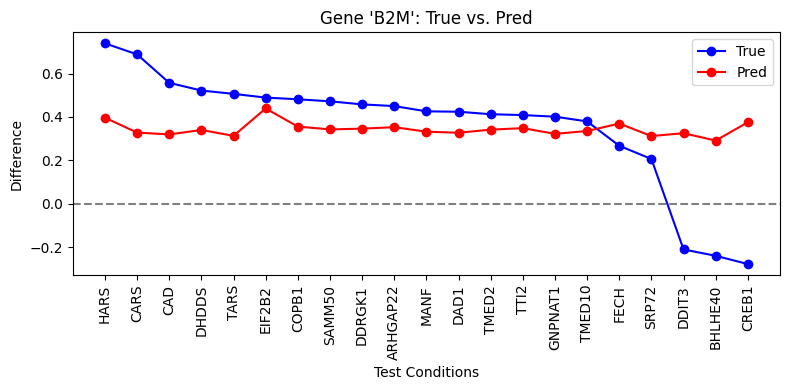

=== Combined ranking for gene 'B2M' ===
              Pred      True  Rank_Pred  Rank_True
HARS      0.396665  0.739532        2.0        1.0
CARS      0.328064  0.688784       14.0        2.0
CAD       0.319514  0.557541       18.0        3.0
DHDDS     0.340115  0.521994       11.0        4.0
TARS      0.312944  0.506657       19.0        5.0
EIF2B2    0.439197  0.489419        1.0        6.0
COPB1     0.355764  0.481642        5.0        7.0
SAMM50    0.342655  0.472251        9.0        8.0
DDRGK1    0.346195  0.458113        8.0        9.0
ARHGAP22  0.352905  0.450245        6.0       10.0
MANF      0.332086  0.426014       13.0       11.0
DAD1      0.327307  0.424185       15.0       12.0
TMED2     0.341657  0.412695       10.0       13.0
TTI2      0.348458  0.408799        7.0       14.0
GNPNAT1   0.322321  0.401360       17.0       15.0
TMED10    0.335279  0.379609       12.0       16.0
FECH      0.369616  0.267061        4.0       17.0
SRP72     0.312037  0.206179       20.0   

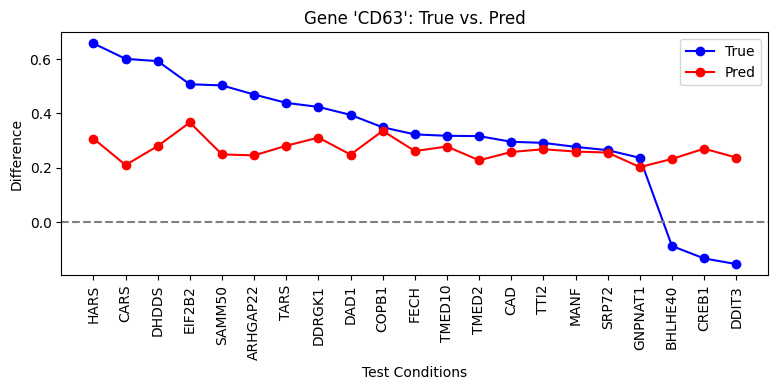

=== Combined ranking for gene 'CD63' ===
              Pred      True  Rank_Pred  Rank_True
HARS      0.307598  0.657878        4.0        1.0
CARS      0.209931  0.600867       20.0        2.0
DHDDS     0.279988  0.592486        6.0        3.0
EIF2B2    0.366648  0.507281        1.0        4.0
SAMM50    0.249114  0.503198       14.0        5.0
ARHGAP22  0.245595  0.469535       16.0        6.0
TARS      0.280998  0.438859        5.0        7.0
DDRGK1    0.311071  0.423993        3.0        8.0
DAD1      0.248494  0.394626       15.0        9.0
COPB1     0.335794  0.348911        2.0       10.0
FECH      0.261504  0.322780       10.0       11.0
TMED10    0.278162  0.317685        7.0       12.0
TMED2     0.227422  0.316453       19.0       13.0
CAD       0.258019  0.295641       12.0       14.0
TTI2      0.268209  0.291627        9.0       15.0
MANF      0.259706  0.276937       11.0       16.0
SRP72     0.255940  0.264707       13.0       17.0
GNPNAT1   0.202375  0.236611       21.0  

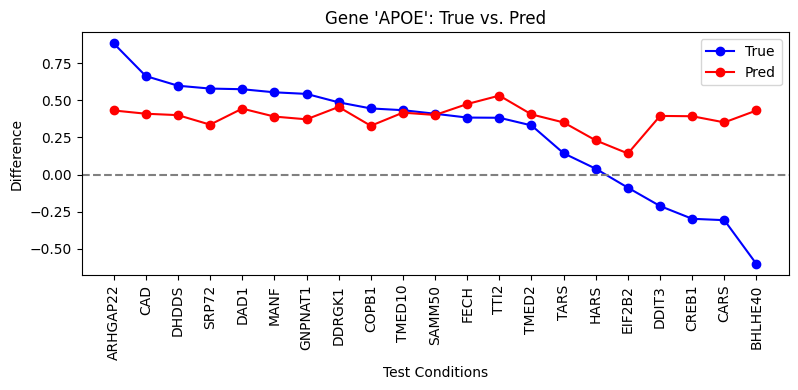

=== Combined ranking for gene 'APOE' ===
              Pred      True  Rank_Pred  Rank_True
ARHGAP22  0.432021  0.884314        6.0        1.0
CAD       0.410146  0.663924        8.0        2.0
DHDDS     0.400544  0.598842       11.0        3.0
SRP72     0.336449  0.579633       18.0        4.0
DAD1      0.444580  0.575256        4.0        5.0
MANF      0.390882  0.554446       14.0        6.0
GNPNAT1   0.372392  0.543689       15.0        7.0
DDRGK1    0.455767  0.486878        3.0        8.0
COPB1     0.328732  0.445735       19.0        9.0
TMED10    0.417387  0.433940        7.0       10.0
SAMM50    0.401662  0.409893       10.0       11.0
FECH      0.475495  0.384194        2.0       12.0
TTI2      0.532230  0.382838        1.0       13.0
TMED2     0.405486  0.331279        9.0       14.0
TARS      0.351288  0.143536       17.0       15.0
HARS      0.230268  0.039250       20.0       16.0
EIF2B2    0.142163 -0.088576       21.0       17.0
DDIT3     0.395259 -0.212106       12.0  

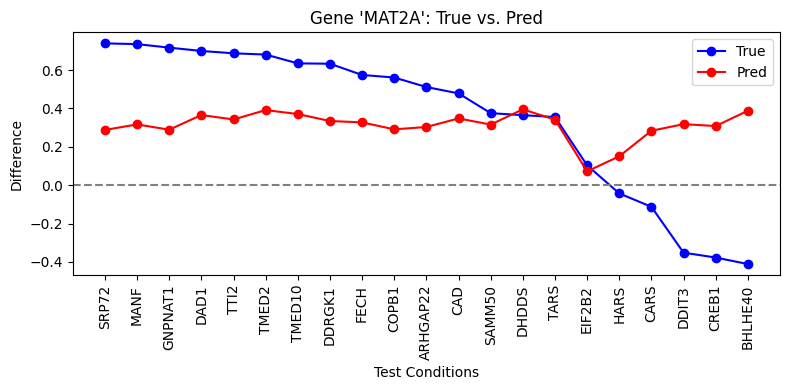

=== Combined ranking for gene 'MAT2A' ===
              Pred      True  Rank_Pred  Rank_True
SRP72     0.288018  0.739232       18.0        1.0
MANF      0.316692  0.735268       12.0        2.0
GNPNAT1   0.289293  0.717012       17.0        3.0
DAD1      0.365535  0.699627        5.0        4.0
TTI2      0.342554  0.687410        7.0        5.0
TMED2     0.391503  0.680880        2.0        6.0
TMED10    0.370879  0.634963        4.0        7.0
DDRGK1    0.334438  0.633068        9.0        8.0
FECH      0.327338  0.574501       10.0        9.0
COPB1     0.291034  0.561211       16.0       10.0
ARHGAP22  0.303376  0.511625       15.0       11.0
CAD       0.347881  0.478485        6.0       12.0
SAMM50    0.315871  0.375487       13.0       13.0
DHDDS     0.395354  0.364832        1.0       14.0
TARS      0.341554  0.355219        8.0       15.0
EIF2B2    0.072143  0.103310       21.0       16.0
HARS      0.150573 -0.042973       20.0       17.0
CARS      0.283550 -0.112756       19.0 

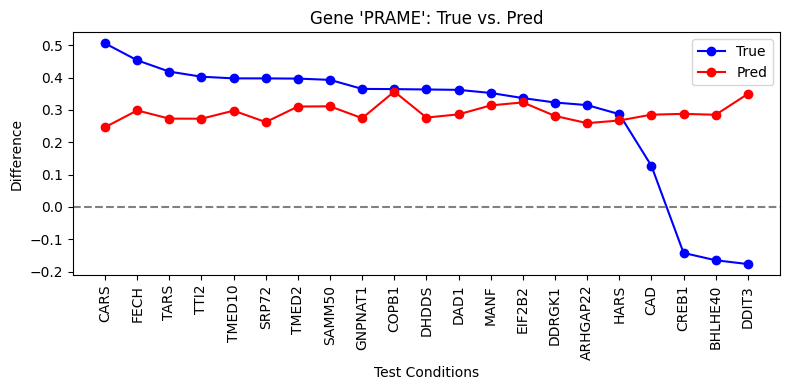

=== Combined ranking for gene 'PRAME' ===
              Pred      True  Rank_Pred  Rank_True
CARS      0.246416  0.505553       21.0        1.0
FECH      0.298383  0.453247        7.0        2.0
TARS      0.273005  0.418302       16.0        3.0
TTI2      0.272750  0.402546       17.0        4.0
TMED10    0.297604  0.397417        8.0        5.0
SRP72     0.262336  0.397300       19.0        6.0
TMED2     0.310412  0.396674        6.0        7.0
SAMM50    0.311013  0.392742        5.0        8.0
GNPNAT1   0.274373  0.364863       15.0        9.0
COPB1     0.356549  0.364221        1.0       10.0
DHDDS     0.276184  0.363077       14.0       11.0
DAD1      0.286262  0.361863       10.0       12.0
MANF      0.313858  0.352297        4.0       13.0
EIF2B2    0.323154  0.336467        3.0       14.0
DDRGK1    0.281306  0.322834       13.0       15.0
ARHGAP22  0.259049  0.314763       20.0       16.0
HARS      0.267234  0.286829       18.0       17.0
CAD       0.285249  0.127015       11.0 

In [64]:
for gene_name in diff_pred_1_pos.columns:
    # Predicted values
    s_pred = diff_pred_1_pos[gene_name]  # Series, index=test_conditions
    # True values
    s_true = diff_true_1_pos[gene_name]  # Series, index=test_conditions
    
    # Combine the two series into a DataFrame for easier comparison
    df_compare = s_pred.to_frame(name='Pred').join(
        s_true.to_frame(name='True')
    )
    
    # Rank the test conditions by the predicted and true values
    df_compare['Rank_Pred'] = df_compare['Pred'].rank(ascending=False, method='dense')
    df_compare['Rank_True'] = df_compare['True'].rank(ascending=False, method='dense')
    df_compare = df_compare.sort_values(by='True', ascending=False)
    
    plt.figure(figsize=(8, 4))
    
    x_vals = df_compare.index  # test_conditions, after sorting by 'True'
    pred_vals = df_compare['Pred'].values
    true_vals = df_compare['True'].values
    
    plt.plot(x_vals, true_vals, marker='o', label='True', color='blue')
    plt.plot(x_vals, pred_vals, marker='o', label='Pred', color='red')

    plt.axhline(0, color='gray', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.xlabel('Test Conditions')
    plt.ylabel('Difference')
    plt.title(f"Gene '{gene_name}': True vs. Pred")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"=== Combined ranking for gene '{gene_name}' ===")
    print(df_compare)
    print("------")


#### 2.1.2 Top 5 Downregulated  Genes from Method 1

In [65]:
cols_1_neg = [g['gene_name'] for g in top_diff_genes_1_neg] # Top 5 genes by frequency
sub_pred_1_neg = df_pred[cols_1_neg] # Predictions for the top 5 genes by frequency
control_1_neg = [control_mean[g['index']] for g in top_diff_genes_1_neg]  # Control mean expression for the top 5 genes by frequency
control_series_1_neg = pd.Series(control_1_neg, index=sub_pred_1_neg.columns)
diff_pred_1_neg = sub_pred_1_neg - control_series_1_neg  # Difference from control 

In [66]:
cols_1_neg = [g['gene_name'] for g in top_diff_genes_1_neg]
sub_true_1_neg = df_true[cols_1_neg]
diff_true_1_neg = sub_true_1_neg - control_series_1_neg

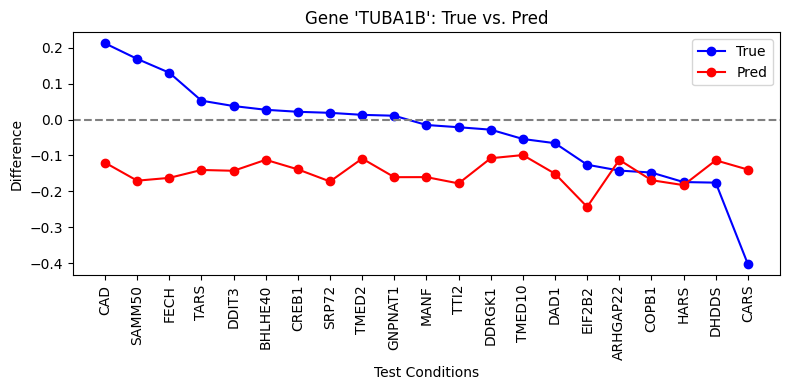

=== Combined ranking for gene 'TUBA1B' ===
              Pred      True  Rank_Pred  Rank_True
CAD      -0.120162  0.212340        7.0        1.0
SAMM50   -0.170438  0.169027       17.0        2.0
FECH     -0.162637  0.130477       15.0        3.0
TARS     -0.140584  0.052599       10.0        4.0
DDIT3    -0.142858  0.037593       11.0        5.0
BHLHE40  -0.112249  0.027211        4.0        6.0
CREB1    -0.138952  0.021590        8.0        7.0
SRP72    -0.172699  0.018700       18.0        8.0
TMED2    -0.108833  0.013070        3.0        9.0
GNPNAT1  -0.160715  0.010601       14.0       10.0
MANF     -0.160536 -0.015195       13.0       11.0
TTI2     -0.178047 -0.021445       19.0       12.0
DDRGK1   -0.107869 -0.028237        2.0       13.0
TMED10   -0.099044 -0.054225        1.0       14.0
DAD1     -0.151113 -0.065983       12.0       15.0
EIF2B2   -0.243529 -0.126006       21.0       16.0
ARHGAP22 -0.112442 -0.142246        5.0       17.0
COPB1    -0.169077 -0.147817       16.0

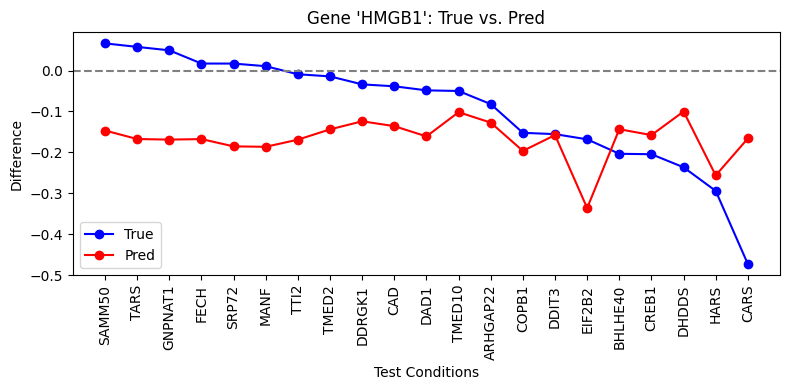

=== Combined ranking for gene 'HMGB1' ===
              Pred      True  Rank_Pred  Rank_True
SAMM50   -0.146576  0.066500        8.0        1.0
TARS     -0.167366  0.057876       13.0        2.0
GNPNAT1  -0.168755  0.049485       15.0        3.0
FECH     -0.167532  0.017164       14.0        4.0
SRP72    -0.185309  0.017114       17.0        5.0
MANF     -0.186375  0.010705       18.0        6.0
TTI2     -0.168897 -0.009051       16.0        7.0
TMED2    -0.143758 -0.014220        7.0        8.0
DDRGK1   -0.124004 -0.033772        3.0        9.0
CAD      -0.135882 -0.038446        5.0       10.0
DAD1     -0.160943 -0.048367       11.0       11.0
TMED10   -0.101730 -0.049913        2.0       12.0
ARHGAP22 -0.127211 -0.081974        4.0       13.0
COPB1    -0.196457 -0.152181       19.0       14.0
DDIT3    -0.157748 -0.155415       10.0       15.0
EIF2B2   -0.336118 -0.168094       21.0       16.0
BHLHE40  -0.143421 -0.203454        6.0       17.0
CREB1    -0.157728 -0.204529        9.0 

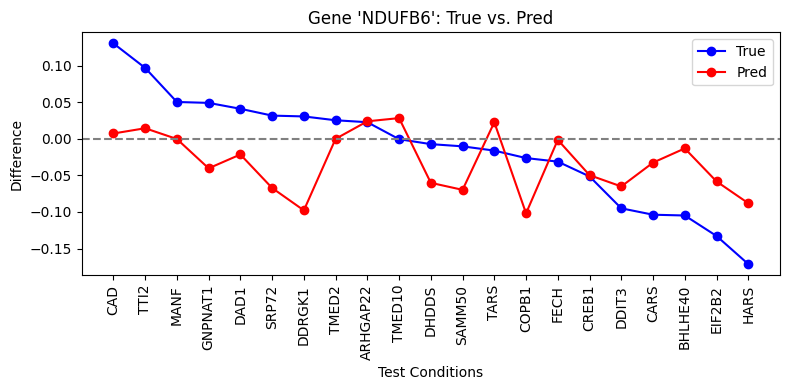

=== Combined ranking for gene 'NDUFB6' ===
              Pred      True  Rank_Pred  Rank_True
CAD       0.007344  0.130617        5.0        1.0
TTI2      0.014534  0.097052        4.0        2.0
MANF     -0.000183  0.050445        7.0        3.0
GNPNAT1  -0.040296  0.049204       12.0        4.0
DAD1     -0.021361  0.041133       10.0        5.0
SRP72    -0.067178  0.031818       17.0        6.0
DDRGK1   -0.097811  0.030675       20.0        7.0
TMED2     0.000049  0.025440        6.0        8.0
ARHGAP22  0.024014  0.022787        2.0        9.0
TMED10    0.028401 -0.000461        1.0       10.0
DHDDS    -0.060141 -0.007210       15.0       11.0
SAMM50   -0.069730 -0.010228       18.0       12.0
TARS      0.022722 -0.016066        3.0       13.0
COPB1    -0.101848 -0.026268       21.0       14.0
FECH     -0.001373 -0.031129        8.0       15.0
CREB1    -0.049659 -0.051358       13.0       16.0
DDIT3    -0.065091 -0.094992       16.0       17.0
CARS     -0.032495 -0.103745       11.0

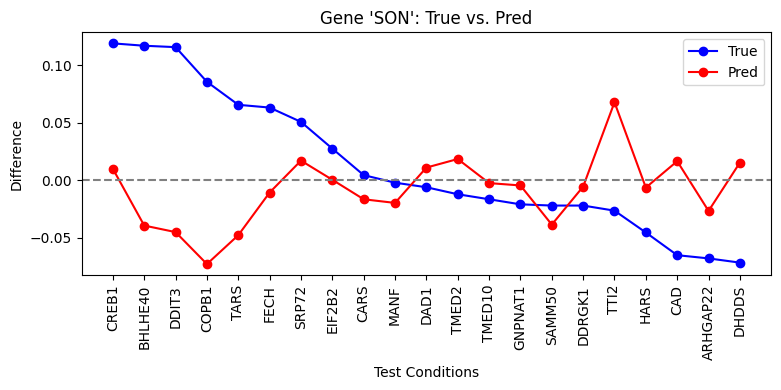

=== Combined ranking for gene 'SON' ===
              Pred      True  Rank_Pred  Rank_True
CREB1     0.009973  0.119191        7.0        1.0
BHLHE40  -0.039406  0.117126       18.0        2.0
DDIT3    -0.045107  0.115909       19.0        3.0
COPB1    -0.072926  0.085715       21.0        4.0
TARS     -0.047788  0.065707       20.0        5.0
FECH     -0.010645  0.063307       13.0        6.0
SRP72     0.017114  0.050826        3.0        7.0
EIF2B2    0.000447  0.027570        8.0        8.0
CARS     -0.016529  0.004485       14.0        9.0
MANF     -0.019696 -0.002087       15.0       10.0
DAD1      0.011061 -0.006053        6.0       11.0
TMED2     0.018516 -0.012165        2.0       12.0
TMED10   -0.002449 -0.016516        9.0       13.0
GNPNAT1  -0.004492 -0.020939       10.0       14.0
SAMM50   -0.038591 -0.021992       17.0       15.0
DDRGK1   -0.005501 -0.021998       11.0       16.0
TTI2      0.067918 -0.026442        1.0       17.0
HARS     -0.006359 -0.045450       12.0   

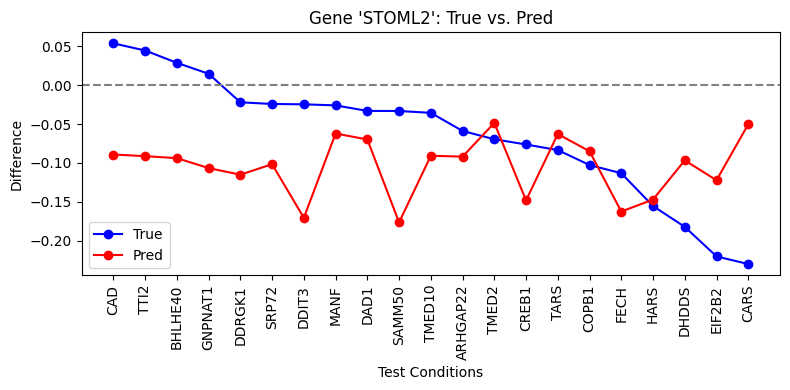

=== Combined ranking for gene 'STOML2' ===
              Pred      True  Rank_Pred  Rank_True
CAD      -0.089217  0.053626        7.0        1.0
TTI2     -0.091311  0.044455        9.0        2.0
BHLHE40  -0.093883  0.028637       11.0        3.0
GNPNAT1  -0.106653  0.014543       14.0        4.0
DDRGK1   -0.115136 -0.022110       15.0        5.0
SRP72    -0.101669 -0.024272       13.0        6.0
DDIT3    -0.170574 -0.024714       20.0        7.0
MANF     -0.062232 -0.026063        3.0        8.0
DAD1     -0.069858 -0.033188        5.0        9.0
SAMM50   -0.176454 -0.033287       21.0       10.0
TMED10   -0.090769 -0.035656        8.0       11.0
ARHGAP22 -0.091953 -0.058936       10.0       12.0
TMED2    -0.048598 -0.069584        1.0       13.0
CREB1    -0.148122 -0.076330       18.0       14.0
TARS     -0.062869 -0.083512        4.0       15.0
COPB1    -0.085049 -0.102710        6.0       16.0
FECH     -0.162539 -0.113270       19.0       17.0
HARS     -0.147069 -0.155430       17.0

In [67]:
for gene_name in diff_pred_1_neg.columns:
    # Predicted values
    s_pred = diff_pred_1_neg[gene_name]  # Series, index=test_conditions
    # True values
    s_true = diff_true_1_neg[gene_name]  # Series, index=test_conditions
    
    # Combine the two series into a DataFrame for easier comparison
    df_compare = s_pred.to_frame(name='Pred').join(
        s_true.to_frame(name='True')
    )
    
    # Rank the test conditions by the predicted and true values
    df_compare['Rank_Pred'] = df_compare['Pred'].rank(ascending=False, method='dense')
    df_compare['Rank_True'] = df_compare['True'].rank(ascending=False, method='dense')
    df_compare = df_compare.sort_values(by='True', ascending=False)
    
    plt.figure(figsize=(8, 4))
    
    x_vals = df_compare.index  # test_conditions, after sorting by 'True'
    pred_vals = df_compare['Pred'].values
    true_vals = df_compare['True'].values
    
    plt.plot(x_vals, true_vals, marker='o', label='True', color='blue')
    plt.plot(x_vals, pred_vals, marker='o', label='Pred', color='red')

    plt.axhline(0, color='gray', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.xlabel('Test Conditions')
    plt.ylabel('Difference')
    plt.title(f"Gene '{gene_name}': True vs. Pred")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"=== Combined ranking for gene '{gene_name}' ===")
    print(df_compare)
    print("------")

#### 2.2 Top 5 genes from Method 2

In [68]:
# Top 5 genes by significance and mean |log2FC|
# As same as the previous method 1
cols_2 = [g['gene_name'] for g in top_diff_genes_2]
sub_pred_2 = df_pred[cols_2]

control_2 = [control_mean[g['index']] for g in top_diff_genes_2]
control_series_2 = pd.Series(control_2, index=sub_pred_2.columns)

diff_pred_2 = sub_pred_2 - control_series_2

# for gene_name in diff_abs_pred_2.columns:
#     diff_series = diff_abs_pred_2[gene_name]
#     # Sort the test conditions by the absolute difference in descending order    
#     sorted_diff_gene = diff_series.sort_values(ascending=False)
    
#     print(f"=== Ranking of test_conditions by absolute difference for gene '{gene_name}' ===")
#     print(sorted_diff_gene) # Print the sorted series
#     print("------")

In [69]:
cols_2 = [g['gene_name'] for g in top_diff_genes_2]
sub_true_2 = df_true[cols_2]
sub_true_2

gene_name   ATP5EP2  HIST1H1E     RPL39    FCER1G   RPSAP58
CREB1      0.461611  0.146228  0.895104  0.374953  0.737940
BHLHE40    0.481794  0.141962  1.023267  0.371855  0.772616
DDIT3      0.427460  0.154070  0.965151  0.335968  0.765616
HARS       0.059173  0.916864  0.217671  0.865852  0.156435
DAD1       0.123090  0.809023  0.260205  0.809358  0.208884
DDRGK1     0.106057  0.808661  0.255606  0.870328  0.181959
SAMM50     0.100130  0.923442  0.263625  0.872452  0.176506
CAD        0.124742  0.922092  0.215094  0.814135  0.200683
GNPNAT1    0.125152  0.902290  0.249037  0.733528  0.180031
TTI2       0.113824  0.710178  0.266826  0.772242  0.177019
MANF       0.118770  0.726647  0.247813  0.785458  0.179337
TARS       0.090123  0.857364  0.253420  0.915576  0.184748
EIF2B2     0.068658  0.982962  0.250458  0.922311  0.164180
ARHGAP22   0.090784  0.812873  0.271180  0.826919  0.201396
SRP72      0.135669  0.905123  0.247475  0.918214  0.172528
TMED10     0.106502  0.714415  0.265672  0.850913  0.170789
COPB1      0.095980  0.586561  0.251408  0.766000  0.159962
FECH       0.110448  0.833039  0.276088  0.852339  0.206036
DHDDS      0.082064  0.748152  0.260084  1.139659  0.136113
CARS       0.096341  0.828763  0.221918  1.424236  0.121421
TMED2      0.104275  0.767907  0.243357  0.829996  0.179005

In [70]:
diff_true_2 = sub_true_2 - control_series_2
diff_true_2

gene_name   ATP5EP2  HIST1H1E     RPL39    FCER1G   RPSAP58
CREB1      0.163743 -0.193457  0.369033 -0.116394  0.394643
BHLHE40    0.183926 -0.197723  0.497197 -0.119491  0.429318
DDIT3      0.129592 -0.185615  0.439081 -0.155379  0.422319
HARS      -0.238695  0.577178 -0.308400  0.374505 -0.186863
DAD1      -0.174778  0.469337 -0.265866  0.318011 -0.134414
DDRGK1    -0.191810  0.468976 -0.270464  0.378982 -0.161338
SAMM50    -0.197738  0.583757 -0.262446  0.381106 -0.166792
CAD       -0.173126  0.582407 -0.310977  0.322789 -0.142615
GNPNAT1   -0.172716  0.562605 -0.277033  0.242181 -0.163267
TTI2      -0.184044  0.370492 -0.259245  0.280895 -0.166279
MANF      -0.179098  0.386962 -0.278257  0.294112 -0.163961
TARS      -0.207745  0.517679 -0.272651  0.424229 -0.158550
EIF2B2    -0.229209  0.643276 -0.275613  0.430964 -0.179118
ARHGAP22  -0.207083  0.473188 -0.254890  0.335572 -0.141901
SRP72     -0.162199  0.565437 -0.278595  0.426867 -0.170769
TMED10    -0.191366  0.374729 -0.260398  0.359566 -0.172509
COPB1     -0.201887  0.246875 -0.274663  0.274653 -0.183336
FECH      -0.187419  0.493354 -0.249982  0.360993 -0.137262
DHDDS     -0.215804  0.408467 -0.265987  0.648313 -0.207185
CARS      -0.201527  0.489078 -0.304152  0.932889 -0.221877
TMED2     -0.193592  0.428222 -0.282714  0.338649 -0.164292

In [71]:
# for gene_name in diff_abs_true_2.columns:
#     diff_series = diff_abs_true_2[gene_name]         
#     sorted_diff_gene = diff_series.sort_values(ascending=False)
    
#     print(f"=== Ranking of test_conditions by absolute difference for gene '{gene_name}' ===")
#     print(sorted_diff_gene)
#     print("------")

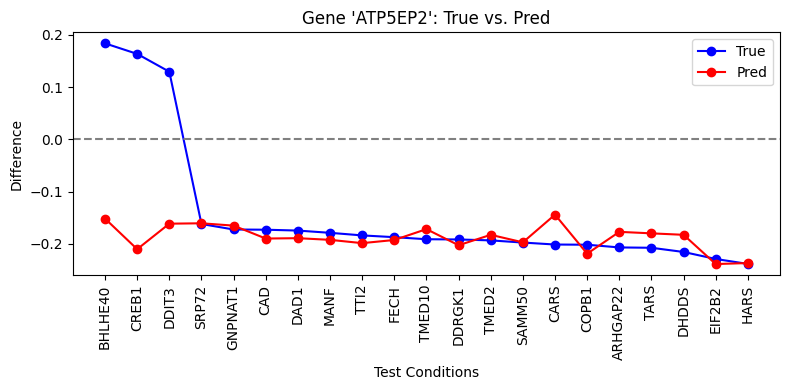

=== Combined ranking for gene 'ATP5EP2' ===
              Pred      True  Rank_Pred  Rank_True
BHLHE40  -0.151875  0.183926        2.0        1.0
CREB1    -0.210452  0.163743       18.0        2.0
DDIT3    -0.161570  0.129592        4.0        3.0
SRP72    -0.160827 -0.162199        3.0        4.0
GNPNAT1  -0.165303 -0.172716        5.0        5.0
CAD      -0.190045 -0.173126       12.0        6.0
DAD1     -0.189362 -0.174778       11.0        7.0
MANF     -0.192543 -0.179098       13.0        8.0
TTI2     -0.198862 -0.184044       16.0        9.0
FECH     -0.192822 -0.187419       14.0       10.0
TMED10   -0.172025 -0.191366        6.0       11.0
DDRGK1   -0.202886 -0.191810       17.0       12.0
TMED2    -0.182934 -0.193592       10.0       13.0
SAMM50   -0.197304 -0.197738       15.0       14.0
CARS     -0.144285 -0.201527        1.0       15.0
COPB1    -0.219093 -0.201887       19.0       16.0
ARHGAP22 -0.177234 -0.207083        7.0       17.0
TARS     -0.180114 -0.207745        8.

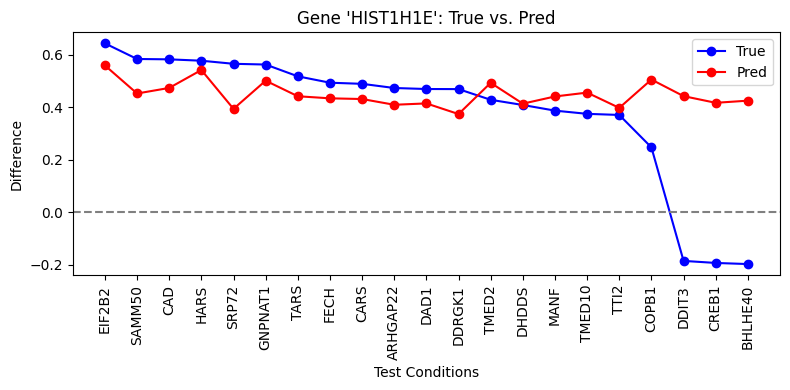

=== Combined ranking for gene 'HIST1H1E' ===
              Pred      True  Rank_Pred  Rank_True
EIF2B2    0.559144  0.643276        1.0        1.0
SAMM50    0.452239  0.583757        8.0        2.0
CAD       0.473486  0.582407        6.0        3.0
HARS      0.541755  0.577178        2.0        4.0
SRP72     0.393674  0.565437       20.0        5.0
GNPNAT1   0.501064  0.562605        4.0        6.0
TARS      0.441751  0.517679       10.0        7.0
FECH      0.433842  0.493354       12.0        8.0
CARS      0.431173  0.489078       13.0        9.0
ARHGAP22  0.409279  0.473188       18.0       10.0
DAD1      0.414465  0.469337       16.0       11.0
DDRGK1    0.373902  0.468976       21.0       12.0
TMED2     0.492909  0.428222        5.0       13.0
DHDDS     0.413467  0.408467       17.0       14.0
MANF      0.440954  0.386962       11.0       15.0
TMED10    0.455644  0.374729        7.0       16.0
TTI2      0.397424  0.370492       19.0       17.0
COPB1     0.505417  0.246875        3

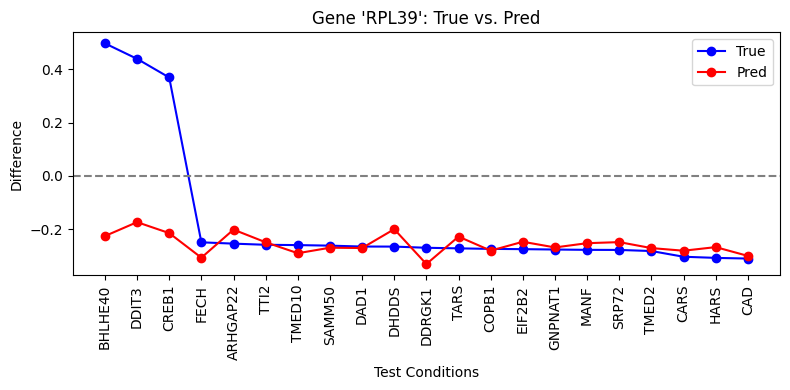

=== Combined ranking for gene 'RPL39' ===
              Pred      True  Rank_Pred  Rank_True
BHLHE40  -0.226436  0.497197        5.0        1.0
DDIT3    -0.174195  0.439081        1.0        2.0
CREB1    -0.215365  0.369033        4.0        3.0
FECH     -0.307736 -0.249982       20.0        4.0
ARHGAP22 -0.202229 -0.254890        3.0        5.0
TTI2     -0.249828 -0.259245        9.0        6.0
TMED10   -0.290907 -0.260398       18.0        7.0
SAMM50   -0.270240 -0.262446       13.0        8.0
DAD1     -0.271385 -0.265866       14.0        9.0
DHDDS    -0.200612 -0.265987        2.0       10.0
DDRGK1   -0.331628 -0.270464       21.0       11.0
TARS     -0.228467 -0.272651        6.0       12.0
COPB1    -0.281222 -0.274663       16.0       13.0
EIF2B2   -0.247896 -0.275613        7.0       14.0
GNPNAT1  -0.269206 -0.277033       12.0       15.0
MANF     -0.253207 -0.278257       10.0       16.0
SRP72    -0.249217 -0.278595        8.0       17.0
TMED2    -0.271646 -0.282714       15.0 

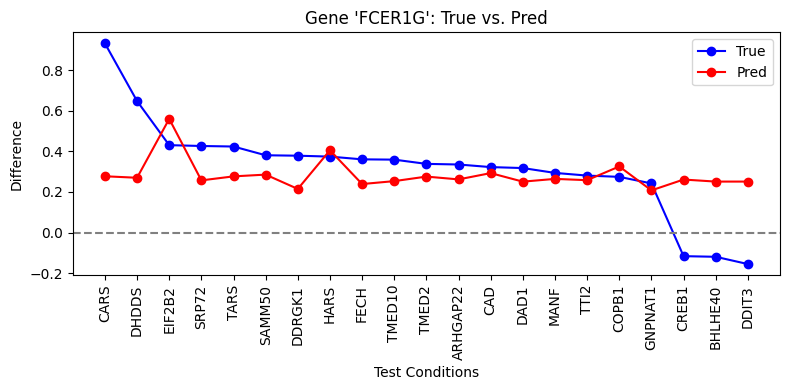

=== Combined ranking for gene 'FCER1G' ===
              Pred      True  Rank_Pred  Rank_True
CARS      0.277543  0.932889        6.0        1.0
DHDDS     0.270176  0.648313        9.0        2.0
EIF2B2    0.560540  0.430964        1.0        3.0
SRP72     0.257295  0.426867       14.0        4.0
TARS      0.277017  0.424229        7.0        5.0
SAMM50    0.285692  0.381106        5.0        6.0
DDRGK1    0.215123  0.378982       20.0        7.0
HARS      0.405692  0.374505        2.0        8.0
FECH      0.239227  0.360993       19.0        9.0
TMED10    0.253591  0.359566       15.0       10.0
TMED2     0.275948  0.338649        8.0       11.0
ARHGAP22  0.262133  0.335572       11.0       12.0
CAD       0.293132  0.322789        4.0       13.0
DAD1      0.250984  0.318011       18.0       14.0
MANF      0.264641  0.294112       10.0       15.0
TTI2      0.258266  0.280895       13.0       16.0
COPB1     0.325886  0.274653        3.0       17.0
GNPNAT1   0.208035  0.242181       21.0

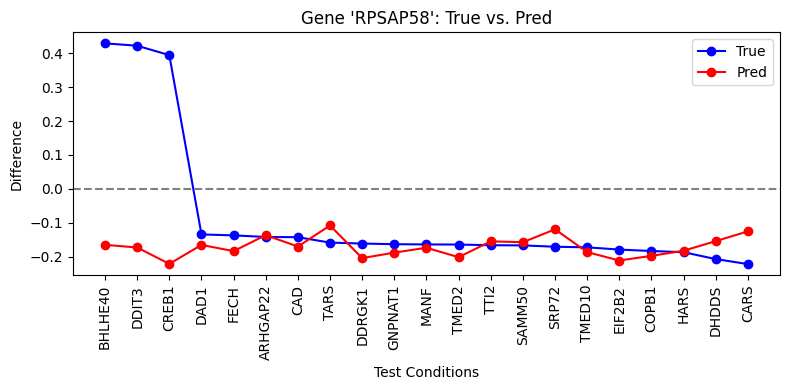

=== Combined ranking for gene 'RPSAP58' ===
              Pred      True  Rank_Pred  Rank_True
BHLHE40  -0.165198  0.429318        8.0        1.0
DDIT3    -0.172959  0.422319       11.0        2.0
CREB1    -0.221376  0.394643       21.0        3.0
DAD1     -0.165357 -0.134414        9.0        4.0
FECH     -0.183736 -0.137262       14.0        5.0
ARHGAP22 -0.136475 -0.141901        4.0        6.0
CAD      -0.170200 -0.142615       10.0        7.0
TARS     -0.108052 -0.158550        1.0        8.0
DDRGK1   -0.204340 -0.161338       19.0        9.0
GNPNAT1  -0.188098 -0.163267       16.0       10.0
MANF     -0.173812 -0.163961       12.0       11.0
TMED2    -0.201520 -0.164292       18.0       12.0
TTI2     -0.154889 -0.166279        6.0       13.0
SAMM50   -0.157377 -0.166792        7.0       14.0
SRP72    -0.119391 -0.170769        2.0       15.0
TMED10   -0.186644 -0.172509       15.0       16.0
EIF2B2   -0.211407 -0.179118       20.0       17.0
COPB1    -0.197639 -0.183336       17.

In [72]:
for gene_name in diff_pred_2.columns:
    # Predicted values
    s_pred = diff_pred_2[gene_name]  # Series, index=test_conditions
    # True values
    s_true = diff_true_2[gene_name]  # Series, index=test_conditions
    
    # Combine the two series into a DataFrame for easier comparison
    df_compare = s_pred.to_frame(name='Pred').join(
        s_true.to_frame(name='True')
    )
    
    df_compare['Rank_Pred'] = df_compare['Pred'].rank(ascending=False, method='dense')
    df_compare['Rank_True'] = df_compare['True'].rank(ascending=False, method='dense')
    df_compare = df_compare.sort_values(by='True', ascending=False)
    
    plt.figure(figsize=(8, 4))
    
    x_vals = df_compare.index  # test_conditions, after sorting by 'True'
    pred_vals = df_compare['Pred'].values
    true_vals = df_compare['True'].values
    
    plt.plot(x_vals, true_vals, marker='o', label='True', color='blue')
    plt.plot(x_vals, pred_vals, marker='o', label='Pred', color='red')

    plt.axhline(0, color='gray', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.xlabel('Test Conditions')
    plt.ylabel('Difference')
    plt.title(f"Gene '{gene_name}': True vs. Pred")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"=== Combined ranking for gene '{gene_name}' ===")
    print(df_compare)
    print("------")


#### 2.3.1 Top 5 Upregulated Genes on Training Set from Method 1

In [73]:
train_conditions = pert_data.set2conditions['train']
test_conditions = pert_data.set2conditions['test']
train_samples = pert_data.adata[pert_data.adata.obs['condition'].isin(train_conditions)]
control_mean = train_samples.X[train_samples.obs['condition'] == 'ctrl', :].toarray().mean(axis=0)  # Mean expression of control samples
train_conditions = [condition for condition in train_conditions if condition != 'ctrl'] # Remove 'ctrl' from the list of conditions

predicted_list = []
for cond in train_conditions:
    parts = cond.split('+')
    gene_to_predict = [p for p in parts if p != 'ctrl'][0] 
    Y_pred = gears_model.predict([[gene_to_predict]])  # Predict the expression of the gene
    predicted_list.append(Y_pred)

In [74]:
arr_list = []
gene_names_arr = []

for item in predicted_list:
    gene_name = list(item.keys())[0]
    arr = item[gene_name]
    
    arr_list.append(arr)
    gene_names_arr.append(gene_name)

predicted_arr = np.vstack(arr_list)

df_pred = pd.DataFrame(
    predicted_arr,
    index=gene_names_arr,  # Perturbation group names
    columns=adata.var['gene_name']  # Gene names
)
df_pred

gene_name  AP006222.2  RP11-54O7.16  RP11-54O7.1  RP11-54O7.3    SAMD11  \
ZNF326      -0.003451 -5.269750e-37    -0.031974    -0.009303 -0.023518   
OST4         0.002736  8.706317e-38     0.018465     0.007279  0.017763   
IER3IP1      0.003521  1.052472e-37     0.026133     0.009630  0.013400   
YIPF5        0.003325  1.191506e-37     0.023172     0.006515  0.013102   
DARS         0.003299  1.355686e-37     0.019614     0.006842  0.016117   
IDH3A        0.002471  3.092339e-38     0.022107     0.005605  0.013377   
IARS2        0.005534  1.122538e-37     0.032120     0.010535  0.027232   
SOCS1        0.003191  1.198647e-37     0.020992     0.006326  0.012793   
UFL1         0.002904  1.273950e-37     0.021282     0.005976  0.013917   
QARS         0.006093  8.295196e-38     0.036394     0.011496  0.028233   
STT3A        0.004964  1.296000e-37     0.022557     0.008116  0.012570   
MRGBP        0.002618  1.647660e-38     0.021194     0.005952  0.014567   
SEL1L        0.004539  1.210985e-37     0.022890     0.006107  0.014942   
PDIA6        0.002602  6.453595e-38     0.020567     0.005722  0.014260   
ATP5B        0.002880  1.147630e-37     0.021323     0.006204  0.018490   
SYVN1        0.002878  2.237782e-03     0.018286     0.005965  0.013850   
MTHFD1       0.001219 -1.949232e-37     0.017491     0.004982  0.008508   
GMPPB        0.002843  1.177685e-37     0.022263     0.005931  0.014462   
TMEM167A     0.003326  1.218506e-37     0.019091     0.008669  0.014931   
NEDD8        0.005027  1.427103e-37     0.019657     0.006072  0.012958   
TELO2        0.002603  3.154914e-38     0.027367     0.005856  0.015701   
HSPA9        0.006298  5.985677e-38     0.040999     0.012862  0.028998   
MRPL39       0.002551  7.030735e-38     0.017913     0.006784  0.015001   
GBF1         0.002900  1.309007e-37     0.018126     0.005976  0.016139   
FARSB        0.004402  1.491150e-37     0.025696     0.009688  0.021439   
SEC63        0.002830  1.107314e-37     0.021440     0.005930  0.014186   
MARS         0.003757  1.385504e-37     0.022740     0.007586  0.020516   
HSD17B12     0.002896  1.339183e-37     0.025462     0.010936  0.012993   
SEC61B       0.002821  1.151656e-37     0.019335     0.007107  0.015249   
ASCC3        0.002666  9.186605e-38     0.018074     0.005792  0.012456   
SARS         0.005407  1.188285e-37     0.028669     0.010329  0.020495   
TTI1         0.002505 -6.798688e-38     0.029107     0.008639  0.014418   
HSPA5        0.006415 -1.996153e-37     0.029006     0.010805  0.017279   
PSMD4        0.003976 -3.624620e-37     0.035857     0.010274  0.014007   
SCYL1        0.006941  1.221067e-37     0.024801     0.006382  0.012914   
SRP68        0.002465  5.044007e-38     0.021878     0.005544  0.011943   
TIMM44       0.007330  1.241436e-37     0.026308     0.011584  0.019888   
PTDSS1       0.002635  3.976046e-38     0.023539     0.008037  0.016253   
HYOU1        0.002633  6.397212e-38     0.025181     0.007142  0.012295   
DDOST        0.006660  1.229132e-37     0.023276     0.006060  0.014094   
SLC35B1      0.004913  1.111872e-37     0.018248     0.005910  0.015513   
CCND3        0.002316 -1.092363e-37     0.027514     0.005943  0.012569   
UFM1         0.002842  1.179619e-37     0.024959     0.008909  0.012487   
CHERP        0.002167 -2.481668e-38     0.022277     0.005185  0.011116   
AARS         0.005705  1.055821e-37     0.032188     0.010842  0.032798   
SRPRB        0.002112 -1.519590e-38     0.017174     0.005070  0.010960   
PPWD1        0.006735  8.881352e-38     0.018058     0.005787  0.014639   
COPZ1        0.004191  1.162570e-37     0.029144     0.011631  0.016140   
EIF2B3       0.005544  1.123174e-37     0.027612     0.010559  0.026948   
SEC61G       0.003039  1.579077e-37     0.018621     0.006258  0.013359   
XRN1         0.002714  8.304981e-38     0.021789     0.005851  0.012393   
P4HB         0.002652  5.409410e-38     0.020644     0.005848  0.012320   
SPCS3        0.003676  1.

In [75]:
train_true_list = []

for cond in train_conditions:
    sub_adata = adata[adata.obs['condition'] == cond]
    mean_expr = sub_adata.X.toarray().mean(axis=0)
    train_true_list.append(mean_expr)

train_arr = np.vstack(train_true_list)

df_true = pd.DataFrame(
    train_arr, 
    index=gene_names_arr, 
    columns=adata.var['gene_name']
)
df_true

gene_name  AP006222.2  RP11-54O7.16  RP11-54O7.1  RP11-54O7.3    SAMD11  \
ZNF326       0.000000           0.0     0.001645     0.001532  0.003365   
OST4         0.000000           0.0     0.005374     0.000000  0.003748   
IER3IP1      0.001063           0.0     0.002717     0.001589  0.004433   
YIPF5        0.000714           0.0     0.010284     0.000811  0.001784   
DARS         0.001735           0.0     0.012271     0.004118  0.006628   
IDH3A        0.000000           0.0     0.006432     0.000000  0.001192   
IARS2        0.000000           0.0     0.006206     0.000959  0.011234   
SOCS1        0.000000           0.0     0.004993     0.001377  0.001299   
UFL1         0.000000           0.0     0.006840     0.000000  0.002708   
QARS         0.000000           0.0     0.010567     0.000000  0.019340   
STT3A        0.000000           0.0     0.001130     0.000000  0.000000   
MRGBP        0.000000           0.0     0.012742     0.001291  0.009985   
SEL1L        0.000000           0.0     0.006034     0.001677  0.002200   
PDIA6        0.000000           0.0     0.002805     0.000000  0.001651   
ATP5B        0.000000           0.0     0.002783     0.000000  0.002391   
SYVN1        0.000000           0.0     0.006725     0.000874  0.005239   
MTHFD1       0.000000           0.0     0.001275     0.000000  0.000000   
GMPPB        0.000000           0.0     0.001071     0.000000  0.002270   
TMEM167A     0.002232           0.0     0.007298     0.000000  0.000000   
NEDD8        0.001471           0.0     0.000000     0.000000  0.002466   
TELO2        0.000000           0.0     0.003065     0.000000  0.006215   
HSPA9        0.001142           0.0     0.003758     0.001189  0.007535   
MRPL39       0.000000           0.0     0.003480     0.000000  0.003609   
GBF1         0.000697           0.0     0.007022     0.001635  0.004516   
FARSB        0.001332           0.0     0.003651     0.008101  0.004058   
SEC63        0.000000           0.0     0.003179     0.000854  0.006654   
MARS         0.000000           0.0     0.007317     0.002771  0.004032   
HSD17B12     0.002617           0.0     0.006649     0.004692  0.005056   
SEC61B       0.000000           0.0     0.004857     0.005580  0.005785   
ASCC3        0.000000           0.0     0.006827     0.000950  0.002674   
SARS         0.003200           0.0     0.016168     0.008981  0.008302   
TTI1         0.000000           0.0     0.006353     0.000000  0.001297   
HSPA5        0.001757           0.0     0.006225     0.003103  0.003462   
PSMD4        0.000000           0.0     0.009069     0.001223  0.001248   
SCYL1        0.000000           0.0     0.005215     0.001725  0.003445   
SRP68        0.000000           0.0     0.003805     0.001869  0.001268   
TIMM44       0.000000           0.0     0.010221     0.000000  0.001601   
PTDSS1       0.000000           0.0     0.003176     0.000000  0.002789   
HYOU1        0.000000           0.0     0.012565     0.001285  0.000518   
DDOST        0.000000           0.0     0.000000     0.000000  0.002575   
SLC35B1      0.000000           0.0     0.006003     0.000000  0.003661   
CCND3        0.000000           0.0     0.012951     0.001660  0.001948   
UFM1         0.000000           0.0     0.001731     0.000000  0.001281   
CHERP        0.000000           0.0     0.000899     0.000000  0.002426   
AARS         0.000000           0.0     0.011509     0.002333  0.004110   
SRPRB        0.000000           0.0     0.014600     0.000000  0.002793   
PPWD1        0.000000           0.0     0.000000     0.006122  0.016607   
COPZ1        0.000000           0.0     0.013008     0.000000  0.002444   
EIF2B3       0.002054           0.0     0.007231     0.000000  0.002647   
SEC61G       0.001154           0.0     0.004063     0.000000  0.004531   
XRN1         0.001207           0.0     0.010884     0.000000  0.004067   
P4HB         0.000000           0.0     0.011296     0.005814  0.002511   
SPCS3        0.000000    

In [76]:
cols_1_pos = [g['gene_name'] for g in top_diff_genes_1_pos] # Top 5 genes by frequency
sub_pred_1_pos = df_pred[cols_1_pos] # Predictions for the top 5 genes by frequency

control_1_pos = [control_mean[g['index']] for g in top_diff_genes_1_pos]  # Control mean expression for the top 5 genes by frequency
control_series_1_pos = pd.Series(control_1_pos, index=sub_pred_1_pos.columns) 

diff_pred_1_pos = sub_pred_1_pos - control_series_1_pos 

cols_1_pos = [g['gene_name'] for g in top_diff_genes_1_pos]
sub_true_1_pos = df_true[cols_1_pos]

diff_true_1_pos = sub_true_1_pos - control_series_1_pos

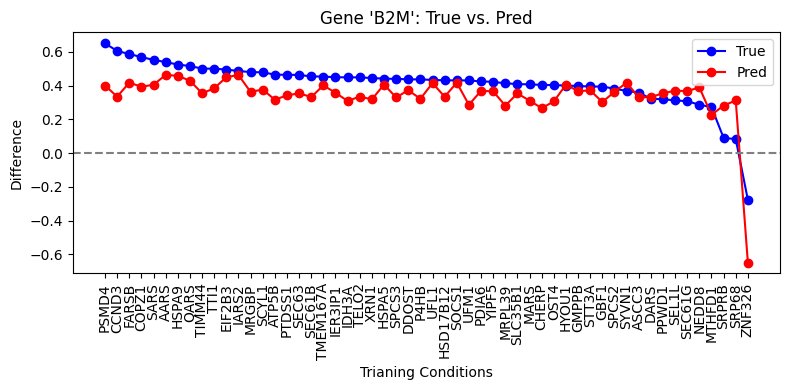

=== Combined ranking for gene 'B2M' ===
              Pred      True  Rank_Pred  Rank_True
PSMD4     0.400588  0.650898       14.0        1.0
CCND3     0.335039  0.605007       35.0        2.0
FARSB     0.417996  0.587672        7.0        3.0
COPZ1     0.393392  0.568932       15.0        4.0
SARS      0.405566  0.552905       12.0        5.0
AARS      0.463618  0.539432        1.0        6.0
HSPA9     0.458034  0.525119        3.0        7.0
QARS      0.429697  0.516028        5.0        8.0
TIMM44    0.354747  0.501073       29.0        9.0
TTI1      0.383976  0.500461       17.0       10.0
EIF2B3    0.450261  0.495272        4.0       11.0
IARS2     0.463000  0.486912        2.0       12.0
MRGBP     0.362888  0.480332       26.0       13.0
SCYL1     0.377181  0.478884       18.0       14.0
ATP5B     0.316640  0.465473       43.0       15.0
PTDSS1    0.342791  0.464021       33.0       16.0
SEC63     0.354179  0.463830       31.0       17.0
SEC61B    0.332886  0.454399       37.0   

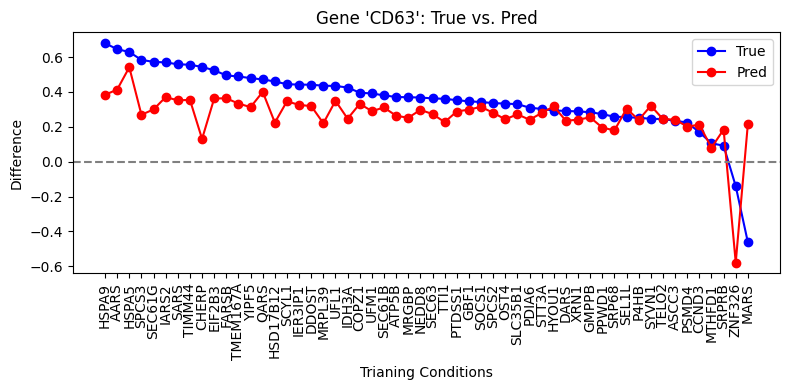

=== Combined ranking for gene 'CD63' ===
              Pred      True  Rank_Pred  Rank_True
HSPA9     0.383587  0.679188        4.0        1.0
AARS      0.413917  0.645648        2.0        2.0
HSPA5     0.541564  0.629176        1.0        3.0
SPCS3     0.269187  0.583821       31.0        4.0
SEC61G    0.300040  0.572773       22.0        5.0
IARS2     0.370677  0.569412        5.0        6.0
SARS      0.351968  0.558895        9.0        7.0
TIMM44    0.354632  0.556196        8.0        8.0
CHERP     0.130789  0.543535       52.0        9.0
EIF2B3    0.362929  0.524369        7.0       10.0
FARSB     0.363576  0.494941        6.0       11.0
TMEM167A  0.333405  0.488807       12.0       12.0
YIPF5     0.313183  0.479553       19.0       13.0
QARS      0.400745  0.471730        3.0       14.0
HSD17B12  0.224474  0.460257       44.0       15.0
SCYL1     0.346530  0.444422       11.0       16.0
IER3IP1   0.325707  0.442375       14.0       17.0
DDOST     0.319010  0.441570       16.0  

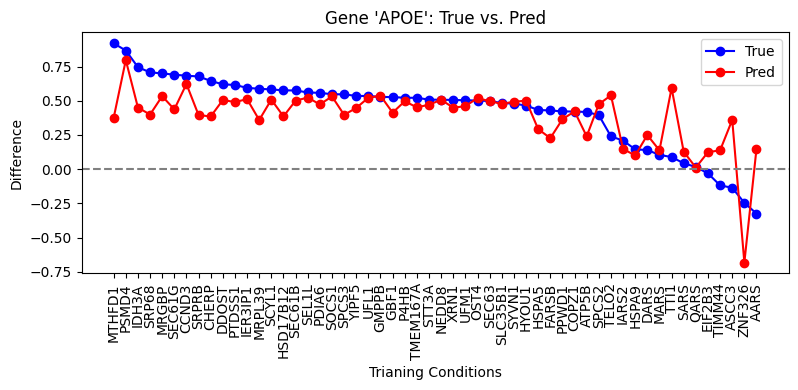

=== Combined ranking for gene 'APOE' ===
              Pred      True  Rank_Pred  Rank_True
MTHFD1    0.375242  0.919734       38.0        1.0
PSMD4     0.797013  0.867024        1.0        2.0
IDH3A     0.450472  0.745453       27.0        3.0
SRP68     0.399128  0.707342       33.0        4.0
MRGBP     0.533633  0.699835        6.0        5.0
SEC61G    0.437072  0.690391       30.0        6.0
CCND3     0.622406  0.683021        2.0        7.0
SRPRB     0.395534  0.677621       35.0        8.0
CHERP     0.385316  0.644944       37.0        9.0
DDOST     0.505316  0.619913       14.0       10.0
PTDSS1    0.490740  0.615592       20.0       11.0
IER3IP1   0.511657  0.594159       11.0       12.0
MRPL39    0.359490  0.587787       41.0       13.0
SCYL1     0.508394  0.582587       12.0       14.0
HSD17B12  0.385860  0.576057       36.0       15.0
SEC61B    0.500778  0.575160       16.0       16.0
SEL1L     0.523437  0.560682        8.0       17.0
PDIA6     0.473329  0.557700       23.0  

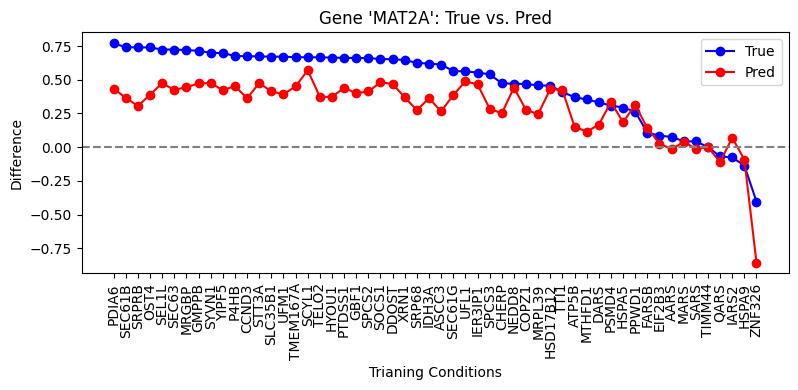

=== Combined ranking for gene 'MAT2A' ===
              Pred      True  Rank_Pred  Rank_True
PDIA6     0.434307  0.770337       15.0        1.0
SEC61B    0.365014  0.740960       29.0        2.0
SRPRB     0.305419  0.740413       34.0        3.0
OST4      0.388623  0.739192       24.0        4.0
SEL1L     0.474280  0.724206        6.0        5.0
SEC63     0.424325  0.724066       17.0        6.0
MRGBP     0.445425  0.719871       12.0        7.0
GMPPB     0.472112  0.714500        7.0        8.0
SYVN1     0.475792  0.699659        4.0        9.0
YIPF5     0.421890  0.698206       19.0       10.0
P4HB      0.453117  0.675903       10.0       11.0
CCND3     0.362155  0.674367       31.0       12.0
STT3A     0.475370  0.673136        5.0       13.0
SLC35B1   0.413546  0.671250       20.0       14.0
UFM1      0.392425  0.671057       23.0       15.0
TMEM167A  0.450102  0.667077       11.0       16.0
SCYL1     0.570510  0.666724        1.0       17.0
TELO2     0.373374  0.666364       26.0 

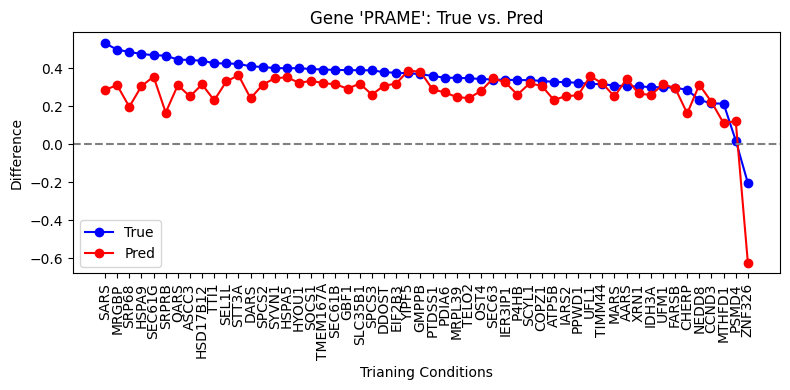

=== Combined ranking for gene 'PRAME' ===
              Pred      True  Rank_Pred  Rank_True
SARS      0.288156  0.532081       32.0        1.0
MRGBP     0.310729  0.498552       25.0        2.0
SRP68     0.197755  0.486665       49.0        3.0
HSPA9     0.305964  0.475826       28.0        4.0
SEC61G    0.356687  0.469586        5.0        5.0
SRPRB     0.167445  0.466858       50.0        6.0
QARS      0.311415  0.446451       24.0        7.0
ASCC3     0.252481  0.444335       41.0        8.0
HSD17B12  0.315317  0.440259       20.0        9.0
TTI1      0.231805  0.426960       47.0       10.0
SEL1L     0.331252  0.425804       11.0       11.0
STT3A     0.363892  0.423621        3.0       12.0
DARS      0.242615  0.410721       45.0       13.0
SPCS2     0.314062  0.407588       22.0       14.0
SYVN1     0.348369  0.401272        7.0       15.0
HSPA5     0.352857  0.400860        6.0       16.0
HYOU1     0.324013  0.400785       13.0       17.0
SOCS1     0.334320  0.396511       10.0 

In [77]:
for gene_name in diff_pred_1_pos.columns:
    # Predicted values
    s_pred = diff_pred_1_pos[gene_name]  # Series, index=test_conditions
    # True values
    s_true = diff_true_1_pos[gene_name]  # Series, index=test_conditions
    
    # Combine the two series into a DataFrame for easier comparison
    df_compare = s_pred.to_frame(name='Pred').join(
        s_true.to_frame(name='True')
    )
    
    # Rank the test conditions by the predicted and true values
    df_compare['Rank_Pred'] = df_compare['Pred'].rank(ascending=False, method='dense')
    df_compare['Rank_True'] = df_compare['True'].rank(ascending=False, method='dense')
    df_compare = df_compare.sort_values(by='True', ascending=False)
    
    plt.figure(figsize=(8, 4))
    
    x_vals = df_compare.index  # test_conditions, after sorting by 'True'
    pred_vals = df_compare['Pred'].values
    true_vals = df_compare['True'].values
    
    plt.plot(x_vals, true_vals, marker='o', label='True', color='blue')
    plt.plot(x_vals, pred_vals, marker='o', label='Pred', color='red')

    plt.axhline(0, color='gray', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.xlabel('Trianing Conditions')
    plt.ylabel('Difference')
    plt.title(f"Gene '{gene_name}': True vs. Pred")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"=== Combined ranking for gene '{gene_name}' ===")
    print(df_compare)
    print("------")


#### 2.3.2 Top 5 Downregulated  Genes on Training Set from Method 1

In [78]:
cols_1_neg = [g['gene_name'] for g in top_diff_genes_1_neg] # Top 5 genes by frequency
sub_pred_1_neg = df_pred[cols_1_neg] # Predictions for the top 5 genes by frequency
control_1_neg = [control_mean[g['index']] for g in top_diff_genes_1_neg]  # Control mean expression for the top 5 genes by frequency
control_series_1_neg = pd.Series(control_1_neg, index=sub_pred_1_neg.columns)
diff_pred_1_neg = sub_pred_1_neg - control_series_1_neg  # Difference from control 

In [79]:
cols_1_neg = [g['gene_name'] for g in top_diff_genes_1_neg]
sub_true_1_neg = df_true[cols_1_neg]
diff_true_1_neg = sub_true_1_neg - control_series_1_neg

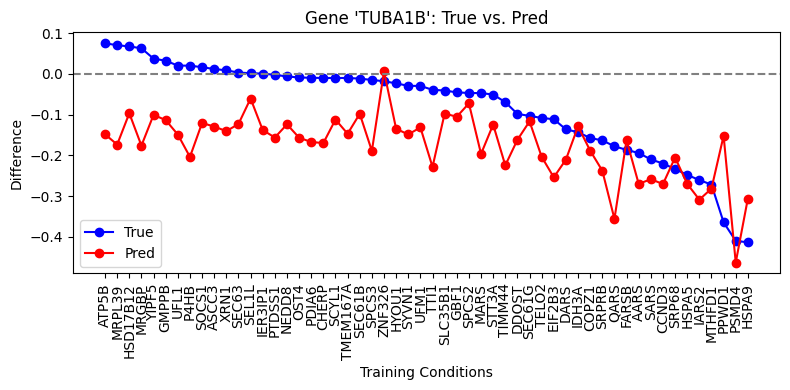

=== Combined ranking for gene 'TUBA1B' ===
              Pred      True  Rank_Pred  Rank_True
ATP5B    -0.148412  0.075277       23.0        1.0
MRPL39   -0.173596  0.070617       33.0        2.0
HSD17B12 -0.096682  0.067534        4.0        3.0
MRGBP    -0.176223  0.063009       34.0        4.0
YIPF5    -0.100649  0.037546        7.0        5.0
GMPPB    -0.113457  0.032473       10.0        6.0
UFL1     -0.148945  0.020455       25.0        7.0
P4HB     -0.203892  0.020355       39.0        8.0
SOCS1    -0.120614  0.016526       12.0        9.0
ASCC3    -0.129355  0.012075       17.0       10.0
XRN1     -0.140613  0.008867       21.0       11.0
SEC63    -0.123088  0.003333       13.0       12.0
SEL1L    -0.060452  0.001809        2.0       13.0
IER3IP1  -0.137857  0.000740       20.0       14.0
PTDSS1   -0.156305 -0.002154       27.0       15.0
NEDD8    -0.123891 -0.006276       14.0       16.0
OST4     -0.156665 -0.008670       28.0       17.0
PDIA6    -0.167344 -0.009482       31.0

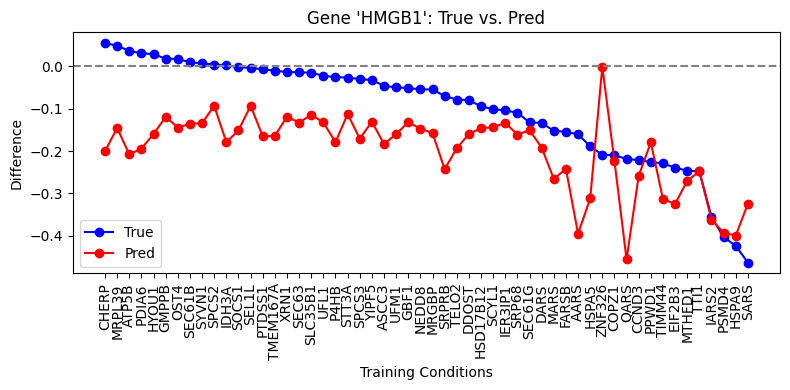

=== Combined ranking for gene 'HMGB1' ===
              Pred      True  Rank_Pred  Rank_True
CHERP    -0.200318  0.053895       37.0        1.0
MRPL39   -0.145499  0.048665       17.0        2.0
ATP5B    -0.208174  0.035635       38.0        3.0
PDIA6    -0.194057  0.030766       36.0        4.0
HYOU1    -0.159996  0.028141       23.0        5.0
GMPPB    -0.119330  0.017638        7.0        6.0
OST4     -0.144686  0.016847       16.0        7.0
SEC61B   -0.135778  0.009286       14.0        8.0
SYVN1    -0.134314  0.006638       13.0        9.0
SPCS2    -0.093405  0.003869        3.0       10.0
IDH3A    -0.179181  0.001746       30.0       11.0
SOCS1    -0.151563 -0.001918       21.0       12.0
SEL1L    -0.093278 -0.004497        2.0       13.0
PTDSS1   -0.165080 -0.007183       28.0       14.0
TMEM167A -0.164695 -0.010715       27.0       15.0
XRN1     -0.118948 -0.013875        6.0       16.0
SEC63    -0.133152 -0.014367       11.0       17.0
SLC35B1  -0.114468 -0.015459        5.0 

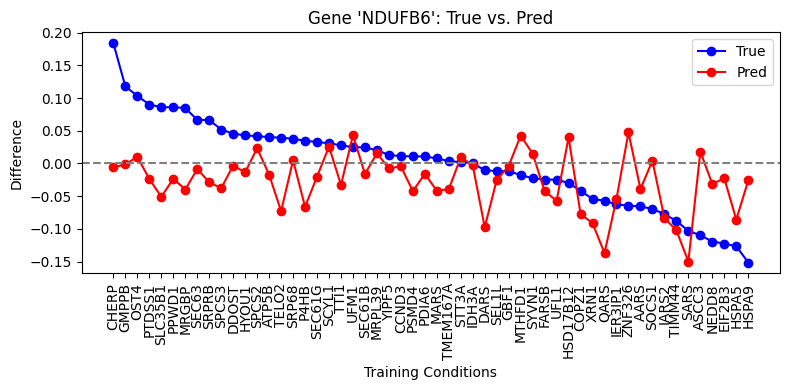

=== Combined ranking for gene 'NDUFB6' ===
              Pred      True  Rank_Pred  Rank_True
CHERP    -0.006195  0.183676       19.0        1.0
GMPPB    -0.001373  0.117641       14.0        2.0
OST4      0.010097  0.103378       10.0        3.0
PTDSS1   -0.023815  0.089967       29.0        4.0
SLC35B1  -0.051027  0.086079       42.0        5.0
PPWD1    -0.023416  0.085812       28.0        6.0
MRGBP    -0.039990  0.084810       38.0        7.0
SEC63    -0.008655  0.066517       21.0        8.0
SRPRB    -0.028619  0.066486       32.0        9.0
SPCS3    -0.037987  0.051746       35.0       10.0
DDOST    -0.003328  0.045471       16.0       11.0
HYOU1    -0.013589  0.042901       22.0       12.0
SPCS2     0.023306  0.041649        6.0       13.0
ATP5B    -0.017160  0.040280       25.0       14.0
TELO2    -0.072938  0.039371       46.0       15.0
SRP68     0.004746  0.037699       12.0       16.0
P4HB     -0.066308  0.034589       45.0       17.0
SEC61G   -0.020175  0.032893       26.0

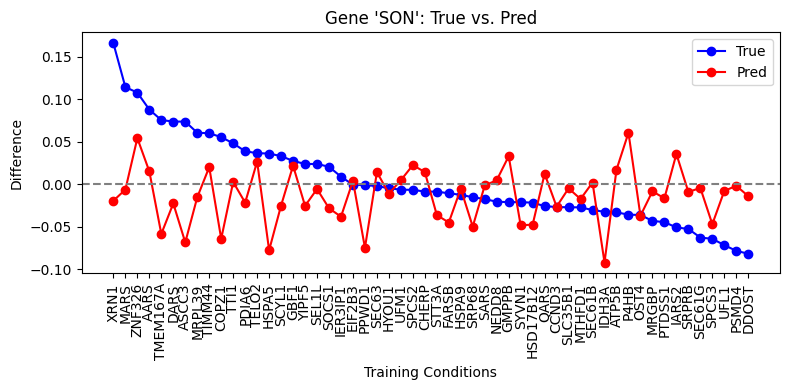

=== Combined ranking for gene 'SON' ===
              Pred      True  Rank_Pred  Rank_True
XRN1     -0.019327  0.165923       34.0        1.0
MARS     -0.006283  0.114354       25.0        2.0
ZNF326    0.054301  0.107861        2.0        3.0
AARS      0.015171  0.087906       10.0        4.0
TMEM167A -0.058422  0.075578       49.0        5.0
DARS     -0.022569  0.073826       36.0        6.0
ASCC3    -0.068399  0.073764       51.0        7.0
MRPL39   -0.015360  0.060674       31.0        8.0
TIMM44    0.020143  0.060085        8.0        9.0
COPZ1    -0.064147  0.055490       50.0       10.0
TTI1      0.002674  0.048205       17.0       11.0
PDIA6    -0.021604  0.038794       35.0       12.0
TELO2     0.026677  0.036670        5.0       13.0
HSPA5    -0.077634  0.036117       53.0       14.0
SCYL1    -0.024975  0.033157       37.0       15.0
GBF1      0.021876  0.027494        7.0       16.0
YIPF5    -0.025399  0.023919       38.0       17.0
SEL1L    -0.005582  0.023884       24.0   

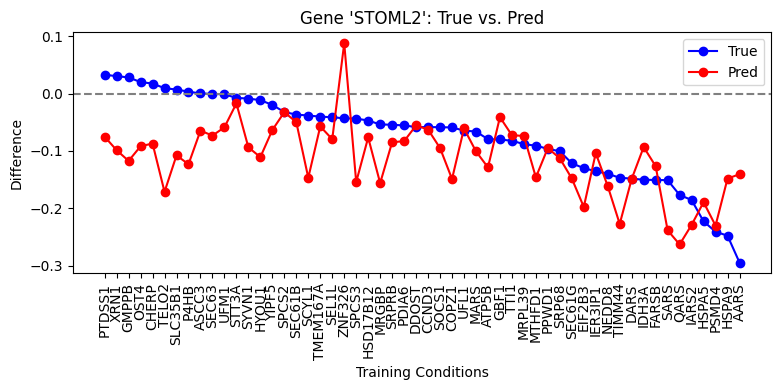

=== Combined ranking for gene 'STOML2' ===
              Pred      True  Rank_Pred  Rank_True
PTDSS1   -0.075256  0.032789       16.0        1.0
XRN1     -0.098758  0.030283       27.0        2.0
GMPPB    -0.117433  0.028139       33.0        3.0
OST4     -0.091895  0.019918       22.0        4.0
CHERP    -0.087124  0.017431       21.0        5.0
TELO2    -0.171361  0.009343       47.0        6.0
SLC35B1  -0.107736  0.006927       30.0        7.0
P4HB     -0.123297  0.003290       34.0        8.0
ASCC3    -0.064682  0.000115       12.0        9.0
SEC63    -0.073327 -0.000546       14.0       10.0
UFM1     -0.058835 -0.001357        8.0       11.0
STT3A    -0.017209 -0.007559        2.0       12.0
SYVN1    -0.093813 -0.008791       24.0       13.0
HYOU1    -0.110838 -0.011544       31.0       14.0
YIPF5    -0.063616 -0.019807       11.0       15.0
SPCS2    -0.032469 -0.032304        3.0       16.0
SEC61B   -0.049933 -0.036653        5.0       17.0
SCYL1    -0.146775 -0.038335       39.0

In [80]:
for gene_name in diff_pred_1_neg.columns:
    # Predicted values
    s_pred = diff_pred_1_neg[gene_name]  # Series, index=test_conditions
    # True values
    s_true = diff_true_1_neg[gene_name]  # Series, index=test_conditions
    
    # Combine the two series into a DataFrame for easier comparison
    df_compare = s_pred.to_frame(name='Pred').join(
        s_true.to_frame(name='True')
    )
    
    # Rank the test conditions by the predicted and true values
    df_compare['Rank_Pred'] = df_compare['Pred'].rank(ascending=False, method='dense')
    df_compare['Rank_True'] = df_compare['True'].rank(ascending=False, method='dense')
    df_compare = df_compare.sort_values(by='True', ascending=False)
    
    plt.figure(figsize=(8, 4))
    
    x_vals = df_compare.index  # test_conditions, after sorting by 'True'
    pred_vals = df_compare['Pred'].values
    true_vals = df_compare['True'].values
    
    plt.plot(x_vals, true_vals, marker='o', label='True', color='blue')
    plt.plot(x_vals, pred_vals, marker='o', label='Pred', color='red')

    plt.axhline(0, color='gray', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.xlabel('Training Conditions')
    plt.ylabel('Difference')
    plt.title(f"Gene '{gene_name}': True vs. Pred")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"=== Combined ranking for gene '{gene_name}' ===")
    print(df_compare)
    print("------")